### <h1><center>Diabetic Retinopathy Detection</center></h1>
<h2><center>Introduction to Deep Learning</center></h2>
<h3><center>DTSA-5511</center></h3>
<h3><center>University of Colorado Boulder</center></h3>
<h3><center>D. Stephen Haynes</center></h3>

# Diabetic Retinopathy Detection
- This project will implement various Convolution Neural Network (CNN) methods to identify the presence of Diabetic Retinopathy in images of human retinas. Diabetic Retinopathy is the leading cause of blindness in human adults and is estimated to affect over 93 million people across the globe. More details on this eye disease can be found on the related Kaggle website or on this Wikipedia page: https://en.wikipedia.org/wiki/Diabetic_retinopathy
- Once the model has been trained on hand-labeled images, a model will be applied to the unlabeled test images to predict and classify the severity of Diabetic Retinopathy present in the image. There are five possible levels that will be applied to each image:
    - 0 - No Diabetic Retinopathy
    - 1 - Mild
    - 2 - Moderate
    - 3 - Severe
    - 4 - Proliferative Diabetic Retinopathy


- The details and datasets related to this competition are available here: https://www.kaggle.com/competitions/diabetic-retinopathy-detection/overview

- The code below will perform the following:
    - Ingest the training labels provided as part of the competition
    - Ingest the file locations for the training and test images
    - Align the training labels with the matching training images
    - Evaluate the datasets for quantity, image dimension, and label distribution
    - Visualize samples from each of the five levels of training data
    - Load the training images and split them into training and validation sets for prediction accuracy evaluation
    - Apply image augmentation techniques to the training data
    - Build a CNN model and train the model on the loaded images
    - Adjust the model architecture and parameters and iterate through additional models to discover improvements
    - Apply the most accurate model to the test data and output the labeling results for submission to Kaggle
- The file will be submitted to the Kaggle competition for evaluation and ranking once the test data has been labeled.

## Convolution Neural Network (CNN)
- Convolution Neural Networks are a class of deep learning neural networks most commonly used in visual image analysis. The most significant benefit of CNNs is their ability to automatically detect important features or patterns in images without human supervision. CNNs are comprised of multiple processing layers, described here:
    - Input Layer: This layer specifies the input shape of the data for consistency in future processing.
    - Two-Dimensional Convolution Layers (Conv2D): These layers are the method's namesake and can apply several filters to the input. Each filter detects different features by performing a convolution operation between filter and input, producing a feature map that captures the local dependencies in the original image.
    - Pooling Layers (MaxPooling2D): These layers reduce the width and height of the input for the following convolution layer, decreasing the computational power needed to process the data. Pooling layers also assist by extracting dominant features that are positionally invariant, creating a more robust feature detection solution.
    - Flatten: This layer converts the multi-dimensional output of the previous layer into a 1-Dimensional vector, suitable for fully-connected layers.
    - Fully Connected Layers (Dense): This layer performs the high-level classification decisioning in the neural network. Neurons in a fully connected layer have complete connections to all activations in the previous layer.
    - Dropout: These layers are used as a regularization technique to prevent overfitting by randomly setting a fraction of input units to 0 during training.
    - Batch Normalization: This normalizes the activations from the previous layer, accelerating training and providing some regularization that helps reduce overfitting.
    - Global Average Pooling: These layers reduce each feature map to a single value by taking the average and reducing the spatial dimensions. These layers are often used in combination with transfer learning models to convert feature maps into a format suitable for fully-connected layers.
    - Callback (Learning Rate Scheduler): These schedulers adjust the learning rate during training based on a predefined schedule.
    - Callback (Early Stopping): This function monitors accuracy and loss metrics and stops the training to prevent overfitting. A patience metric is used to determine how many epochs without improvement will be observed before training is stopped.

## The Dataset
The data provided as part of the Kaggle Competition contains 17,563 pairs of training images and 26,788 pairs of test images. Each pair of images is from a single patient and contains a retina scan of the left and right eyes. All combined, there are over 88,000 individual images of various resolution and quality. Prior to importing the images directly from the Kaggle site, I performed some resizing of each image to a common resolution of 88x132 and loaded the training and test image sets into separate .tfrecord archives. A .csv file also accompianies the training data and contains the hand-labeled Diabetic Retinopathy levels for each image.
- The code below will load the necessary Python libraries, adjust TensorFlow settings, suppress warning messages, and import the image and label data needed for this project.

In [ ]:
# Import necessary libraries
import os
import glob
import warnings
import contextlib
import random
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
from tensorflow.keras.layers import Input, Layer, GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import LearningRateScheduler, EarlyStopping
from tensorflow.keras.applications import VGG16, EfficientNetB0
from tensorflow.keras.models import load_model

from collections import Counter, defaultdict

from sklearn.metrics import confusion_matrix, classification_report
from sklearn.utils.class_weight import compute_class_weight
from sklearn.exceptions import UndefinedMetricWarning

# Check TensorFlow version
print(f"TensorFlow version: {tf.__version__}")

# Enable eager execution mode
tf.config.run_functions_eagerly(True)

# Suppress specific TensorFlow warnings
warnings.filterwarnings('ignore', message="Even though the `tf.config.experimental_run_functions_eagerly` option is set")

# Suppress specific scikit-learn warnings
warnings.filterwarnings('ignore', category=UndefinedMetricWarning)

2024-06-24 15:42:04.149214: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-06-24 15:42:04.149328: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-06-24 15:42:04.403588: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


TensorFlow version: 2.15.0


In [ ]:
# List all available GPUs
gpus = tf.config.list_physical_devices('GPU')
print("Num GPUs Available: ", len(gpus), gpus)

# Set memory growth on GPUs to prevent allocation errors
#for gpu in gpus:
#    tf.config.experimental.set_memory_growth(gpu, True)

Num GPUs Available:  2 [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]


### Define functions to be used through this project.

In [ ]:
# Function to ingest images with labels
def parse_tfrecord_fn(example):
    feature_description = {
        'height': tf.io.FixedLenFeature([], tf.int64),
        'width': tf.io.FixedLenFeature([], tf.int64),
        'depth': tf.io.FixedLenFeature([], tf.int64),
        'label': tf.io.FixedLenFeature([], tf.int64),
        'image_raw': tf.io.FixedLenFeature([], tf.string),
    }
    example = tf.io.parse_single_example(example, feature_description)
    image = tf.io.decode_raw(example['image_raw'], tf.uint8)
    label = example['label']
    height = example['height']
    width = example['width']
    depth = example['depth']
    image = tf.reshape(image, [height, width, depth])
    return image, label


# Function to ingest images without labels
def parse_tfrecord_fn_no_label(example):
    feature_description = {
        'height': tf.io.FixedLenFeature([], tf.int64),
        'width': tf.io.FixedLenFeature([], tf.int64),
        'depth': tf.io.FixedLenFeature([], tf.int64),
        'image_raw': tf.io.FixedLenFeature([], tf.string),
    }
    example = tf.io.parse_single_example(example, feature_description)
    image = tf.io.decode_raw(example['image_raw'], tf.uint8)
    height = example['height']
    width = example['width']
    depth = example['depth']
    image = tf.reshape(image, [height, width, depth])
    return image


# Function to load images from tfrecord files
def load_dataset_from_tfrecords(directory, pattern, has_labels=True):
    files = glob.glob(f"{directory}/{pattern}")
    dataset = tf.data.TFRecordDataset(files)
    if has_labels:
        return dataset.map(parse_tfrecord_fn)  # For training data with labels
    else:
        return dataset.map(parse_tfrecord_fn_no_label)  # For test data without labels


# Function to count unique labels
def count_unique_labels(dataset):
    label_counter = Counter()
    for _, label in dataset:
        label_counter[label.numpy()] += 1
    return label_counter


# Function to collect image dimensions from labeled or unlabeled dataset
def get_one_image_dimensions(dataset):
    for image in dataset.take(1):  # Take only one sample from the dataset
        if isinstance(image, tuple):  # For labeled dataset (train)
            img, label = image
            print("Image dimensions (train dataset):", img.numpy().shape)
        else:  # For unlabeled dataset (test)
            img = image
            print("Image dimensions (dataset):", img.numpy().shape)


# Count the number of images
def count_images(dataset):
    return sum(1 for _ in dataset)


# Show samples of the training data for each level
def display_images_by_level(dataset):
    fig, axs = plt.subplots(5, 5, figsize=(15, 15))  # 5 levels, 5 images each
    level_count = {i: 0 for i in range(5)}

    for image, label in dataset:
        level = label.numpy()
        if level_count[level] < 5:
            i = level_count[level]
            axs[level, i].imshow(image.numpy())
            axs[level, i].set_title(f'Level {level}')
            axs[level, i].axis('off')
            level_count[level] += 1
            if all(count == 5 for count in level_count.values()):
                break

    plt.show()


# Function to split dataset into training and validation at 80/20 split
def split_dataset(dataset, train_size=0.8, shuffle=True, shuffle_size=10000):
    if shuffle:
        dataset = dataset.shuffle(shuffle_size)
    dataset_size = sum(1 for _ in dataset)
    train_size = int(train_size * dataset_size)
    train_dataset = dataset.take(train_size)
    val_dataset = dataset.skip(train_size)
    return train_dataset, val_dataset


# Function to print shape of image and label before modeling
def display_image_shapes(dataset):
    for image, label in dataset.take(1):  # Adjust the number taken as necessary
        print("Image shape:", image.numpy().shape)
        print("Label:", label.numpy())


# Function to create a balanced subset with 700 samples of each label
def create_balanced_subset(dataset, target_count=700):
    # Convert dataset to a list of (image, label) tuples
    data_list = list(dataset.as_numpy_iterator())

    # Create a dictionary to store the target number of samples for each label
    sampled_data = defaultdict(list)

    # Shuffle the data to ensure randomness
    random.shuffle(data_list)

    # Populate the dictionary with the target number of samples for each label
    for image, label in data_list:
        if len(sampled_data[label]) < target_count:
            sampled_data[label].append((image, label))
        if all(len(sampled_data[l]) >= target_count for l in range(5)):
            break

    # Combine the sampled data into a single list
    balanced_data = [sample for level_samples in sampled_data.values() for sample in level_samples]

    # Convert the balanced data back into a TensorFlow dataset
    images, labels = zip(*balanced_data)
    balanced_dataset = tf.data.Dataset.from_tensor_slices((list(images), list(labels)))

    return balanced_dataset


# Function to split the balanced dataset into training and validation sets
def split_dataset(dataset, split_ratio=0.8):
    # Convert the dataset to a list of (image, label) tuples
    data_list = list(dataset.as_numpy_iterator())

    # Separate data by labels
    label_data = defaultdict(list)
    for image, label in data_list:
        label_data[label].append((image, label))

    # Split each label's data into training and validation sets
    train_data, val_data = [], []
    for label, items in label_data.items():
        random.shuffle(items)  # Shuffle the items for randomness
        split_index = int(len(items) * split_ratio)
        train_data.extend(items[:split_index])
        val_data.extend(items[split_index:])

    # Convert the lists back into TensorFlow datasets
    train_images, train_labels = zip(*train_data)
    val_images, val_labels = zip(*val_data)

    train_dataset = tf.data.Dataset.from_tensor_slices((list(train_images), list(train_labels)))
    val_dataset = tf.data.Dataset.from_tensor_slices((list(val_images), list(val_labels)))

    return train_dataset, val_dataset


# Function to suppress stdout temporarily
@contextlib.contextmanager
def suppress_stdout():
    with open(os.devnull, 'w') as devnull:
        old_stdout = sys.stdout
        sys.stdout = devnull
        try:
            yield
        finally:
            sys.stdout = old_stdout


# Function to compute confusion matrix without individual prediction printing
def compute_confusion_matrix(model, data, steps):
    true_labels = []
    predicted_labels = []

    with suppress_stdout():
        for images, labels in data.take(steps):
            predictions = model.predict(images)
            predicted_labels.extend(np.argmax(predictions, axis=1))
            true_labels.extend(labels.numpy())

    return confusion_matrix(true_labels, predicted_labels), classification_report(true_labels, predicted_labels, output_dict=False)

### Load the image datasets and training labels.

In [ ]:
# Loading datasets with and without labels
train_dataset = load_dataset_from_tfrecords("../input/eyes-full-88x132", "train_data_*.tfrecord", has_labels=True)
test_dataset = load_dataset_from_tfrecords("../input/eyes-full-88x132", "test_data_*.tfrecord", has_labels=False)

# Load training labels
train_labels = pd.read_csv("../input/eyes-full-88x132/train_labels.csv")

# Exploratory Data Analysis (EDA):


In [ ]:
# Count the number of images in each dataset
num_train_images = count_images(train_dataset)
num_test_images = count_images(test_dataset)
print("Number of train images:", num_train_images)
print("Number of test images:", num_test_images)

Number of train images: 35126
Number of test images: 53576


In [ ]:
# Display dimensions for an image from both datasets
get_one_image_dimensions(train_dataset)
get_one_image_dimensions(test_dataset)

Image dimensions (train dataset): (88, 132, 3)
Image dimensions (dataset): (88, 132, 3)


In [ ]:
# Display training label .head() and .info()
print(train_labels.head())
print()
train_labels.info()

      image  level
0   10_left      0
1  10_right      0
2   13_left      0
3  13_right      0
4   15_left      1

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35126 entries, 0 to 35125
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   image   35126 non-null  object
 1   level   35126 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 549.0+ KB


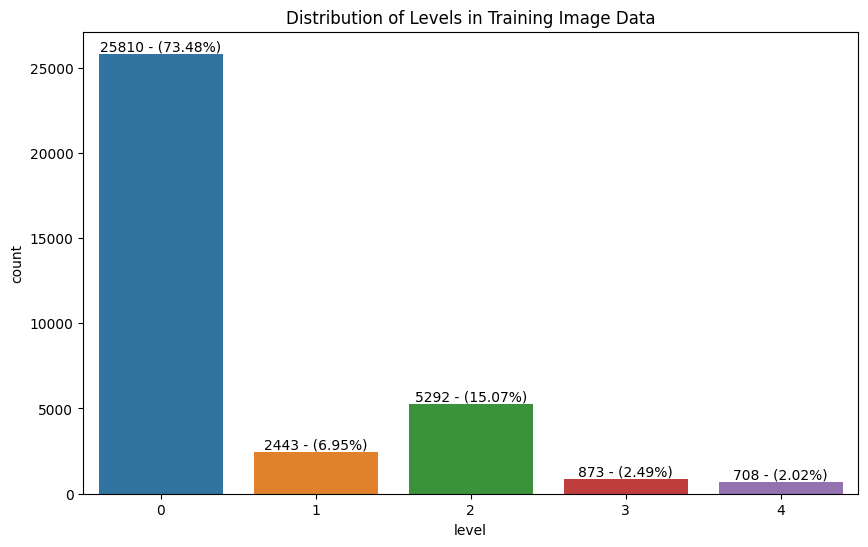

In [ ]:
# Calculate the count and percentage of each label
label_counts = train_labels['level'].value_counts()
total_count = len(train_labels)
label_percentages = (label_counts / total_count) * 100

# Combine the counts and percentages into a DataFrame for easy access
label_info = pd.DataFrame({
    'count': label_counts,
    'percentage': label_percentages
})

# Plot the label distribution
plt.figure(figsize=(10, 6))
ax = sns.countplot(x='level', data=train_labels)
plt.title("Distribution of Levels in Training Image Data")

# Annotate with counts and percentages
for p in ax.patches:
    height = p.get_height()
    level = p.get_x() + p.get_width() / 2.0
    count = label_info.loc[int(level), 'count']
    percentage = label_info.loc[int(level), 'percentage']
    ax.annotate(f'{count} - ({percentage:.2f}%)', (p.get_x() + p.get_width() / 2., height),
                ha='center', va='bottom')

plt.show()

### Define Class Weights
- We'll need to ensure our model training considers the significant imbalance of images for each classification level. To do that, we'll calculate the class weights for each value and ensure we apply those weights when training our models.

- EDIT - The class weight concept didn't pan out, so the quantities were reset to 700 each so the weights would also be equal. The rest of the code proceeds with the balanced training data and ignores the class weights.

In [ ]:
# Define the level distribution
levels = np.array([0, 1, 2, 3, 4])
#quantities = np.array([25810, 2443, 5292, 873, 708]) # original version
quantities = np.array([700, 700, 700, 700, 700]) # modified version for balanced dataset
# Create a list of class labels based on quantities
class_labels = []
for level, quantity in zip(levels, quantities):
    class_labels.extend([level] * quantity)

class_labels = np.array(class_labels)

# Calculate class weights
class_weights = compute_class_weight('balanced', classes=levels, y=class_labels)
class_weights_dict = dict(zip(levels, class_weights))
print("Class weights:", class_weights_dict)


Class weights: {0: 1.0, 1: 1.0, 2: 1.0, 3: 1.0, 4: 1.0}


In [ ]:
# Count the unique labels in the train dataset
label_counts = count_unique_labels(train_dataset)

# Print the counts
print("Label counts:", label_counts)

Label counts: Counter({0: 25810, 2: 5292, 1: 2443, 3: 873, 4: 708})


In [ ]:
# Create the balanced subset
balanced_train_dataset = create_balanced_subset(train_dataset)

# Verify the distribution of levels in the balanced dataset
balanced_label_count = count_unique_labels(balanced_train_dataset)

# Print the counts
print("Balanced data level distribution:", balanced_label_count)

Balanced data level distribution: Counter({0: 700, 2: 700, 3: 700, 1: 700, 4: 700})


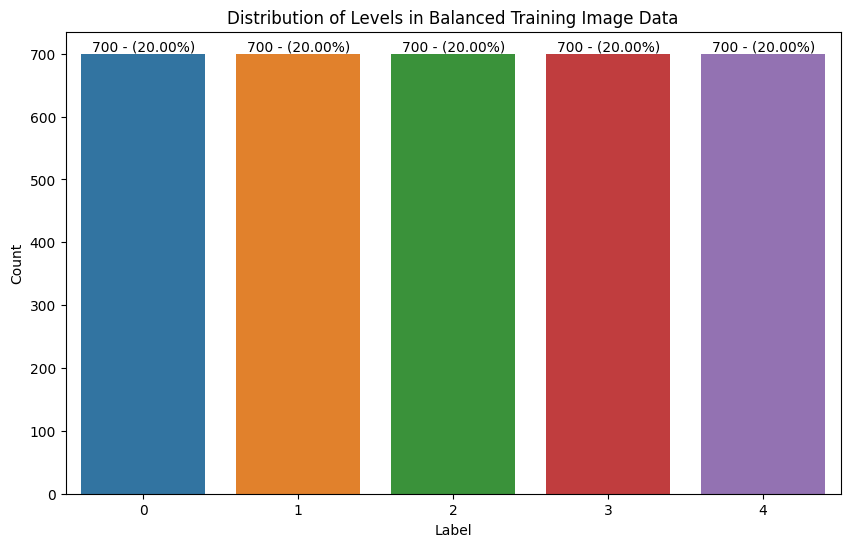

In [ ]:
# Create a DataFrame from balanced_label_count for easier plotting
balanced_label_info = pd.DataFrame.from_dict(balanced_label_count, orient='index', columns=['count'])
balanced_label_info['percentage'] = (balanced_label_info['count'] / balanced_label_info['count'].sum()) * 100

# Plot the label distribution
plt.figure(figsize=(10, 6))
ax = sns.barplot(x=balanced_label_info.index, y=balanced_label_info['count'])
plt.title("Distribution of Levels in Balanced Training Image Data")

# Annotate with counts and percentages
for p in ax.patches:
    height = p.get_height()
    level = int(p.get_x() + p.get_width() / 2.0)
    count = balanced_label_info.loc[level, 'count']
    percentage = balanced_label_info.loc[level, 'percentage']
    ax.annotate(f'{count} - ({percentage:.2f}%)', (p.get_x() + p.get_width() / 2., height),
                ha='center', va='bottom')

plt.xlabel("Label")
plt.ylabel("Count")
plt.show()

### Now that we have a balanced training set, let's make sure our training and validation split is balanced as well.

In [ ]:
# Split the balanced dataset into training and validation sets
train_dataset_bal, val_dataset_bal = split_dataset(balanced_train_dataset)

# Verify the distribution of levels in the training and validation datasets
print("Training data level distribution:", count_unique_labels(train_dataset_bal))
print("Validation data level distribution:", count_unique_labels(val_dataset_bal))

Training data level distribution: Counter({0: 560, 2: 560, 3: 560, 1: 560, 4: 560})
Validation data level distribution: Counter({0: 140, 2: 140, 3: 140, 1: 140, 4: 140})


### Now we have proper training and validation sets, perfectly distributed amongst the five label classifications.
### Let's take a look at some of the images we'll be training with.

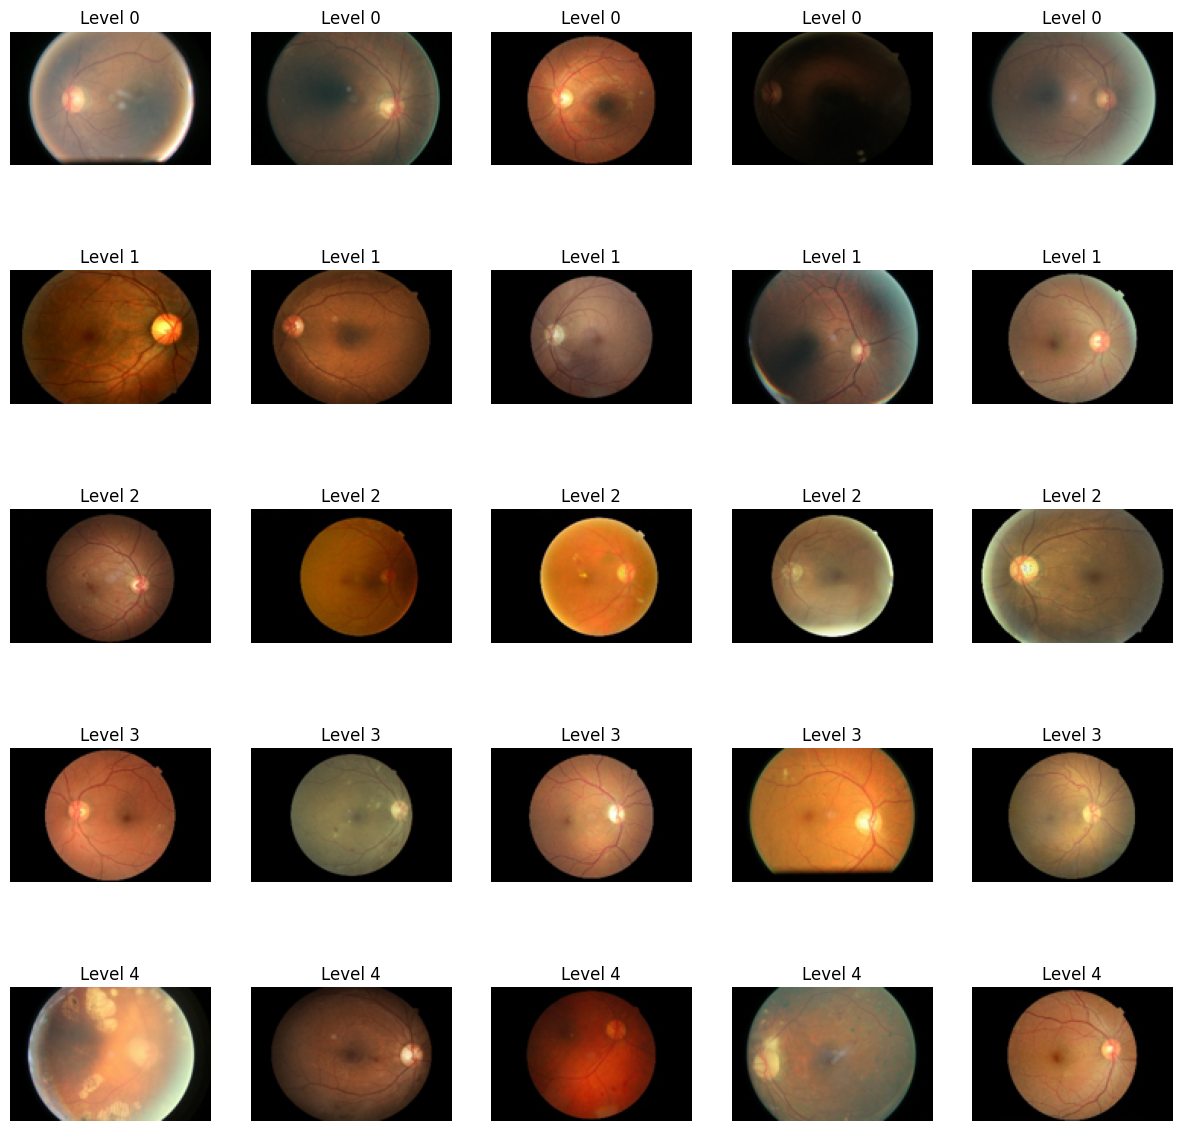

In [ ]:
# Show samples of the training images - 5 of each level
display_images_by_level(train_dataset_bal)

## EDA Results
- We're working with nearly 90,000 RGB images that each have a resolution of 88x132. Unfortunately, the training images are very heavily weighted toward Level 0 classification which can make the tasks ahead more challenging. We'll need to use the calculated class weights or the balanced training and validation datasets to create accurate predictions.
- Even without any training as an ophthalmologist, it is obvious there are some differences in the displayed images of all five levels. However, we'll rely on our CNN models to detect these patterns and correctly predict the test image classifications.

# Model Architecture
- Below, we'll iterate through six different CNN models of various build. Each model architecture will be laid out in text and through visualizations within the code segments. We'll also visualize our accuracy results with a line plot and confusion matrix for each model to identify the need to modify future model architectures and improve results.
- In each model, we will use a variety of augmentations to ensure the images have more variance which will help create a more generalized prediction model.
- We'll also implement different layers within each CNN to find a combination that provides the best accuracy values.
- When training the models, we will also apply different batch sizes, number of epochs, and employ learning-rate and early stopping techniques to ensure we avoid overfitting.

# Model 1 Architecture
- To start things off, we'll train a model with minimal augmentation, simple architecture, and small batches.- To start things off, we'll train a model with minimal augmentation, simple architecture, and small batches.


- Augmentations:
    - Horizontal flip
    - Random contrast adjustments
- Model Definition:
    - Input layer: 88x132x3
    - Convolution Layer 1: 32 filters, 3x3 kernel, ReLU activation
    - MaxPooling Layer 1: 2x2 pooling
    - Convolution Layer 2: 64 filters, 3x3 kernel, ReLU activation
    - MaxPooling Layer 2: 2x2 pooling
    - Flatten Layer: Converts the 3D feature maps to 1D feature vector
    - Dense Layer 1: 128 units, ReLU activation
    - Output Layer: 5 units, softmax activation for multi-class classification
- Model Compilation:
     - Optimizer: Adam
     - Loss Function: Sparse Categorical Crossentropy
     - Metrics: Accuracy
- Model Training:
     - Epochs: 10
     - Steps per Epoch:5000 / 16
     - Validation Steps: 1250 / 16

In [ ]:
# Split the train_dataset
#train_data, val_data = split_dataset(train_dataset)

# Define data augmentation using TensorFlow functions
def augment_images(image, label):
    # Randomly flip the image horizontally
    image = tf.image.random_flip_left_right(image)
    # Randomly change the contrast of the image
    image = tf.image.random_contrast(image, 0.8, 1.2)
    return image, label

# Augment train_data and set batch size for both datasets
train1 = train_dataset_bal.map(augment_images).batch(16).repeat()
val1 = val_dataset_bal.batch(16).repeat()

# Display the image shape for training and validation datasets
#display_image_shapes(train1)
#display_image_shapes(val1)

In [ ]:
# Enable dual-GPU processing for TensorFlow
strategy = tf.distribute.MirroredStrategy()
with strategy.scope():

    # Define the model
    model1 = tf.keras.Sequential([
        tf.keras.layers.InputLayer(shape=(88, 132, 3)),
        tf.keras.layers.Conv2D(32, (3, 3), activation='relu'),
        tf.keras.layers.MaxPooling2D(2, 2),
        tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
        tf.keras.layers.MaxPooling2D(2, 2),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dense(5, activation='softmax')
    ])

    # Compile the model
    model1.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Display model summary
model1.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 86, 130, 32)    │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 43, 65, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 41, 63, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 20, 31, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 39680)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     5,079,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 5)              │           645 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,099,205 (19.45 MB)

 Trainable params: 5,099,205 (19.45 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Train the model
history1 = model1.fit(train1,
                      validation_data=val1,
                      epochs=10,
                      steps_per_epoch=5000 // 16,
                      validation_steps=1250 // 16,
                      class_weight=class_weights_dict)

Epoch 1/10
312/312 ━━━━━━━━━━━━━━━━━━━━ 47s 130ms/step - accuracy: 0.7135 - loss: 357.2832 - val_accuracy: 0.2058 - val_loss: 1.8760
Epoch 2/10
312/312 ━━━━━━━━━━━━━━━━━━━━ 39s 126ms/step - accuracy: 0.2543 - loss: 2.4174 - val_accuracy: 0.1968 - val_loss: 2.1017
Epoch 3/10
312/312 ━━━━━━━━━━━━━━━━━━━━ 39s 126ms/step - accuracy: 0.3236 - loss: 11.3569 - val_accuracy: 0.1806 - val_loss: 82.0983
Epoch 4/10
312/312 ━━━━━━━━━━━━━━━━━━━━ 40s 128ms/step - accuracy: 0.5978 - loss: 10.0443 - val_accuracy: 0.2194 - val_loss: 1.6285
Epoch 5/10
312/312 ━━━━━━━━━━━━━━━━━━━━ 39s 125ms/step - accuracy: 0.4701 - loss: 32.4426 - val_accuracy: 0.2331 - val_loss: 1.6151
Epoch 6/10
312/312 ━━━━━━━━━━━━━━━━━━━━ 39s 126ms/step - accuracy: 0.6088 - loss: 8.4834 - val_accuracy: 0.1516 - val_loss: 3.0518
Epoch 7/10
312/312 ━━━━━━━━━━━━━━━━━━━━ 39s 125ms/step - accuracy: 0.4953 - loss: 2.0595 - val_accuracy: 0.2387 - val_loss: 1.6459
Epoch 8/10
312/312 ━━━━━━━━━━━━━━━━━━━━ 39s 126ms/step - accuracy: 0.3374 - l

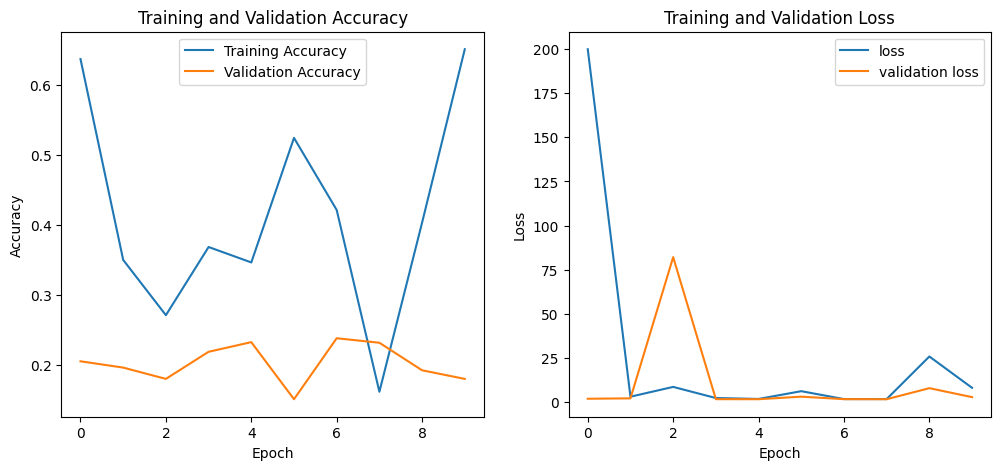

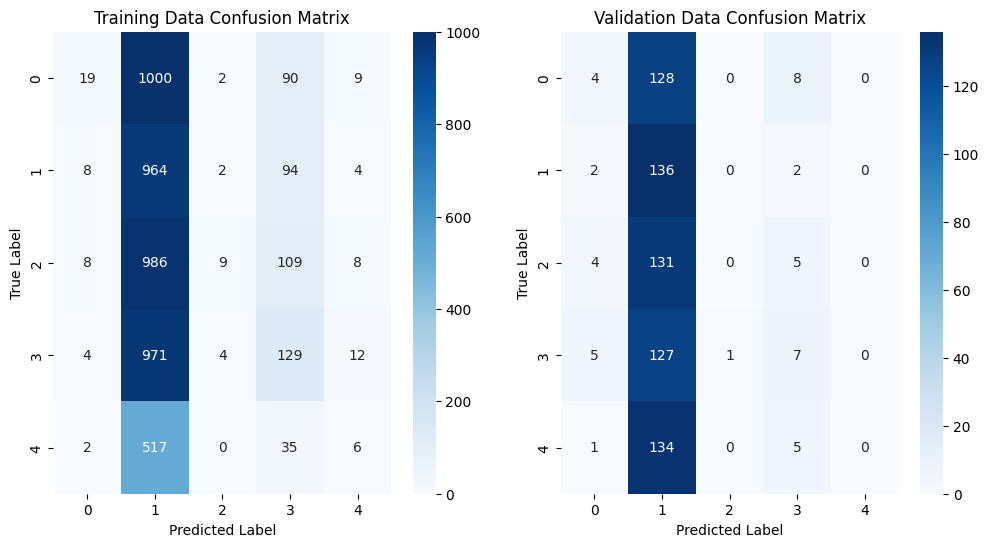

In [ ]:
# Save model files
model1.save('/kaggle/working/model1.h5')
model1.save_weights('/kaggle/working/model1.weights.h5')

# Plot training & validation accuracy values
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history1.history['accuracy'], label='Training Accuracy')
plt.plot(history1.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history1.history['loss'], label='loss')
plt.plot(history1.history['val_loss'], label='validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()


# Calculate confusion matrices for training and validation data
train_conf_matrix, train_class_report = compute_confusion_matrix(model1, train1, steps=5000 // 16)
val_conf_matrix, val_class_report = compute_confusion_matrix(model1, val_dataset_bal.batch(16), steps=1250 // 16)

# Plot confusion matrices
plt.figure(figsize=(12,6))
plt.subplot(1, 2, 1)
sns.heatmap(train_conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Training Data Confusion Matrix')

plt.subplot(1, 2, 2)
sns.heatmap(val_conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Validation Data Confusion Matrix')
plt.show()


# Display raw accuracy values
#history1.history

## Model 1 Analysis:
- Not great validation accuracy values and it seems almost everything is being classified to Level 1.

# Model 2 Architecture:
- In this model, we'll add brightness and contrast augmentations. We'll add a third convolution layer, two additional dense layers, and dropout layers for regulation.



- Augmentations:
    - Horizontal flip
    - Vertical flip
    - Random brightness adjustments
    - Random contrast adjustments
- Model Definition:
    - Input Layer: 88x132x3
    - Convolution Layer 1: 32 filters, 3x3 kernel, ReLU activation
    - MaxPooling Layer 1: 2x2 pooling
    - Convolution Layer 2: 64 filters, 3x3 kernel, ReLU activation
    - MaxPooling Layer 2: 2x2 pooling
    - Convolution Layer 3: 128 filters, 3x3 kernel, ReLU activation
    - MaxPooling Layer 3: 2x2 pooling
    - Flatten Layer: Converts the 3D feature maps to 1D feature vector
    - Dense Layer 1: 256 units, ReLU activation
    - Dropout Layer 1: Dropout rate of 0.5 for regularization
    - Dense Layer 2: 128 units, ReLU activation
    - Dropout Layer 2: Dropout rate of 0.5 for regularization
    - Output Layer: 5 units, softmax activation for multi-class classification
- Model Compilation:
    - Optimizer: Adam with a learning rate of 0.001
    - Loss Function: Sparse Categorical Crossentropy
    - Metrics: Accuracy
- Model Training:
    - Epochs: 10
    - Steps per Epoch: 5000 / 16
    - Validation Steps: 1250 / 16
    - Class Weights: Applied to handle class imbalance

In [ ]:
# Reload train_dataset and split
#train_data, val_data = split_dataset(train_dataset)

# Define data augmentation using TensorFlow functions
def augment_images(image, label):
    # Convert image to float32 for more flexible operations
    image = tf.cast(image, tf.float32)
    # Randomly flip the image horizontally
    image = tf.image.random_flip_left_right(image)
    # Randomly flip the image vertically
    image = tf.image.random_flip_up_down(image)
    # Randomly change the brightness of the image
    image = tf.image.random_brightness(image, max_delta=0.1)
    # Randomly change the contrast of the image
    image = tf.image.random_contrast(image, lower=0.9, upper=1.1)
    # Make sure the image is still in [0, 255] and convert back to uint8
    image = tf.clip_by_value(image, 0.0, 255.0)
    image = tf.cast(image, tf.uint8)

    return image, label

# Augment train_data and set batch size for both datasets
train2 = train_dataset_bal.map(augment_images).batch(16).repeat()
val2 = val_dataset_bal.batch(16).repeat()

# Display the image shape for training and validation datasets
#display_image_shapes(train2)
#display_image_shapes(val2)


In [ ]:
# Enable dual-GPU processing for TensorFlow
strategy = tf.distribute.MirroredStrategy()
with strategy.scope():

    # Define the model
    model2 = tf.keras.Sequential([
        tf.keras.layers.InputLayer(input_shape=(88, 132, 3)),
        tf.keras.layers.Conv2D(32, (3, 3), activation='relu'),
        tf.keras.layers.MaxPooling2D(2, 2),
        tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
        tf.keras.layers.MaxPooling2D(2, 2),
        tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
        tf.keras.layers.MaxPooling2D(2, 2),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(256, activation='relu'),
        tf.keras.layers.Dropout(0.5),  # Add dropout for regularization
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dropout(0.5),  # Add another dropout layer
        tf.keras.layers.Dense(5, activation='softmax')
    ])

    # Compile the model
    model2.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Display model summary
model2.summary()

/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/input_layer.py:25: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_2 (Conv2D)               │ (None, 86, 130, 32)    │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 43, 65, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 41, 63, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 20, 31, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 18, 29, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 9, 14, 128)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 16128)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 256)            │     4,129,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 5)              │           645 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,255,813 (16.23 MB)

 Trainable params: 4,255,813 (16.23 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Train the model
history2 = model2.fit(train2,
                      validation_data=val2,
                      epochs=10,
                      steps_per_epoch=5000 // 16,
                      validation_steps=1250 // 16,
                      class_weight=class_weights_dict)

Epoch 1/10
312/312 ━━━━━━━━━━━━━━━━━━━━ 62s 191ms/step - accuracy: 0.8025 - loss: 11.3373 - val_accuracy: 0.2058 - val_loss: 10.4616
Epoch 2/10
312/312 ━━━━━━━━━━━━━━━━━━━━ 59s 189ms/step - accuracy: 0.3972 - loss: 2.5723 - val_accuracy: 0.2323 - val_loss: 1.5912
Epoch 3/10
312/312 ━━━━━━━━━━━━━━━━━━━━ 59s 190ms/step - accuracy: 0.4114 - loss: 2.1223 - val_accuracy: 0.2323 - val_loss: 1.6484
Epoch 4/10
312/312 ━━━━━━━━━━━━━━━━━━━━ 60s 191ms/step - accuracy: 0.2775 - loss: 1.6348 - val_accuracy: 0.1677 - val_loss: 4.2566
Epoch 5/10
312/312 ━━━━━━━━━━━━━━━━━━━━ 59s 189ms/step - accuracy: 0.3867 - loss: 1.8173 - val_accuracy: 0.2186 - val_loss: 1.6508
Epoch 6/10
312/312 ━━━━━━━━━━━━━━━━━━━━ 59s 191ms/step - accuracy: 0.2771 - loss: 1.6365 - val_accuracy: 0.2016 - val_loss: 1.6342
Epoch 7/10
312/312 ━━━━━━━━━━━━━━━━━━━━ 59s 189ms/step - accuracy: 0.4769 - loss: 1.6697 - val_accuracy: 0.1097 - val_loss: 2.7672
Epoch 8/10
312/312 ━━━━━━━━━━━━━━━━━━━━ 60s 192ms/step - accuracy: 0.2808 - loss:

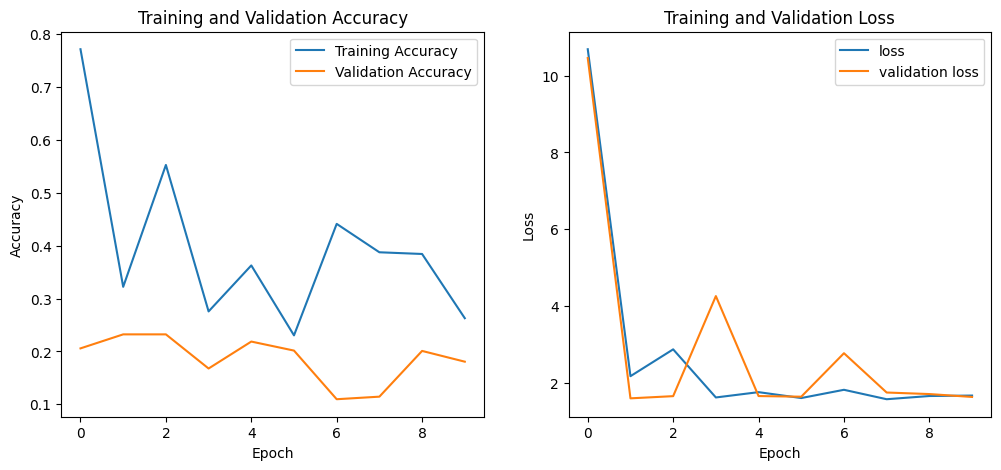

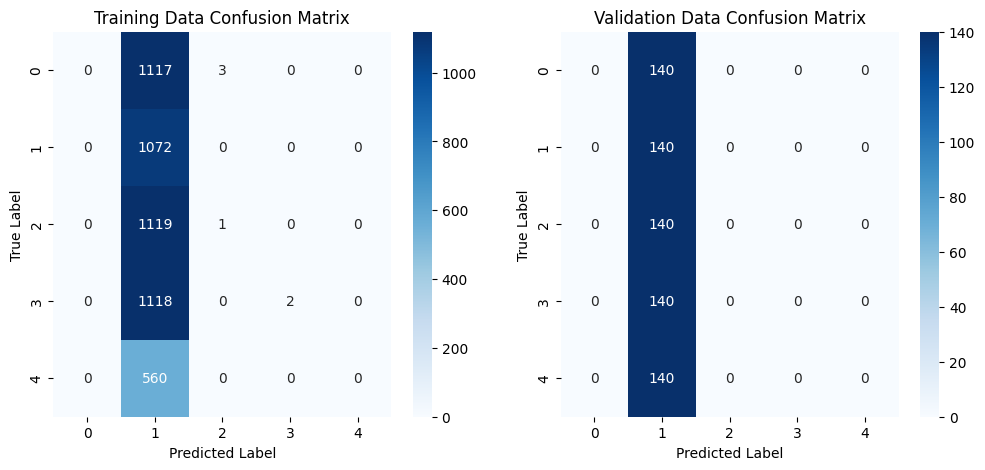

In [ ]:
# Save model files
model2.save('/kaggle/working/model2.h5')
model2.save_weights('/kaggle/working/model2.weights.h5')

# Plot training & validation accuracy values
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history2.history['accuracy'], label='Training Accuracy')
plt.plot(history2.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history2.history['loss'], label='loss')
plt.plot(history2.history['val_loss'], label='validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()


# Calculate confusion matrices for training and validation data
train_conf_matrix, train_class_report = compute_confusion_matrix(model2, train2, steps=5000 // 16)
val_conf_matrix, val_class_report = compute_confusion_matrix(model2, val_dataset_bal.batch(16), steps=1250 // 16)

# Plot confusion matrices
plt.figure(figsize=(12,5))
plt.subplot(1, 2, 1)
sns.heatmap(train_conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Training Data Confusion Matrix')

plt.subplot(1, 2, 2)
sns.heatmap(val_conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Validation Data Confusion Matrix')
plt.show()


# Display raw accuracy values
#history2.history

## Model 2 Analysis:
- Similar validation accuracy results in the 20% range and every one of the validation labels predicted level 1.

# Model 3 Architecture:
- No structural changes made, but we'll increase the batch size to 32.



- Augmentations:
    - Horizontal flip
    - Vertical flip
    - Random brightness adjustments
    - Random contrast adjustments
- Model Definition:
    - Input Layer: 88x132x3
     - Convolution Layer 1: 32 filters, 3x3 kernel, ReLU activation
     - MaxPooling Layer 1: 2x2 pooling
     - Convolution Layer 2: 64 filters, 3x3 kernel, ReLU activation
     - MaxPooling Layer 2: 2x2 pooling
     - Convolution Layer 3: 128 filters, 3x3 kernel, ReLU activation
     - MaxPooling Layer 3: 2x2 pooling
     - Flatten Layer: Converts the 3D feature maps to 1D feature vector
     - Dense Layer 1: 256 units, ReLU activation
     - Dropout Layer 1: 50% dropout for regularization
     - Dense Layer 2: 128 units, ReLU activation
     - Dropout Layer 2: 50% dropout for regularization
     - Output Layer: 5 units, softmax activation for multi-class classification
- Model Compilation:
    - Optimizer: Adam with learning rate 0.001
    - Loss Function: Sparse Categorical Crossentropy
    - Metrics: Accuracy
- Model Training:
    - Epochs: 10
    - Steps per Epoch: 5000 / 32
    - Validation Steps: 1250 / 32
    - Class Weights: Applied to handle class imbalance

In [ ]:
# Reload train_dataset and split
#train_data, val_data = split_dataset(train_dataset)

# Define data augmentation using TensorFlow functions
def augment_images(image, label):
    # Convert image to float32 for more flexible operations
    image = tf.cast(image, tf.float32)
    # Randomly flip the image horizontally
    image = tf.image.random_flip_left_right(image)
    # Randomly flip the image vertically
    image = tf.image.random_flip_up_down(image)
    # Randomly change the brightness of the image
    image = tf.image.random_brightness(image, max_delta=0.1)
    # Randomly change the contrast of the image
    image = tf.image.random_contrast(image, lower=0.9, upper=1.1)
    # Make sure the image is still in [0, 255] and convert back to uint8
    image = tf.clip_by_value(image, 0.0, 255.0)
    image = tf.cast(image, tf.uint8)

    return image, label

# Augment train_data and set batch size for both datasets
train3 = train_dataset_bal.map(augment_images).batch(32).repeat()
val3 = val_dataset_bal.batch(32).repeat()

# Display the image shape for training and validation datasets
#display_image_shapes(train3)
#display_image_shapes(val3)


In [ ]:
# Enable dual-GPU processing for TensorFlow
strategy = tf.distribute.MirroredStrategy()
with strategy.scope():

    # Define the model
    model3 = tf.keras.Sequential([
        tf.keras.layers.InputLayer(input_shape=(88, 132, 3)),
        tf.keras.layers.Conv2D(32, (3, 3), activation='relu'),
        tf.keras.layers.MaxPooling2D(2, 2),
        tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
        tf.keras.layers.MaxPooling2D(2, 2),
        tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
        tf.keras.layers.MaxPooling2D(2, 2),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(256, activation='relu'),
        tf.keras.layers.Dropout(0.5),  # Add dropout for regularization
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dropout(0.5),  # Add another dropout layer
        tf.keras.layers.Dense(5, activation='softmax')
    ])

    # Compile the model
    model3.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Display model summary
model3.summary()

/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/input_layer.py:25: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_5 (Conv2D)               │ (None, 86, 130, 32)    │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 43, 65, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 41, 63, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 20, 31, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 18, 29, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 9, 14, 128)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 16128)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 256)            │     4,129,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 5)              │           645 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,255,813 (16.23 MB)

 Trainable params: 4,255,813 (16.23 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Train the model
history3 = model3.fit(train3,
                      validation_data=val3,
                      epochs=10,
                      steps_per_epoch=5000 // 32,
                      validation_steps=1250 // 32,
                     class_weight=class_weights_dict)

Epoch 1/10
156/156 ━━━━━━━━━━━━━━━━━━━━ 34s 200ms/step - accuracy: 0.5776 - loss: 10.0416 - val_accuracy: 0.2186 - val_loss: 12.1781
Epoch 2/10
156/156 ━━━━━━━━━━━━━━━━━━━━ 31s 196ms/step - accuracy: 0.2789 - loss: 2.4870 - val_accuracy: 0.1613 - val_loss: 1.6397
Epoch 3/10
156/156 ━━━━━━━━━━━━━━━━━━━━ 30s 193ms/step - accuracy: 0.3657 - loss: 2.4604 - val_accuracy: 0.1677 - val_loss: 1.6817
Epoch 4/10
156/156 ━━━━━━━━━━━━━━━━━━━━ 30s 193ms/step - accuracy: 0.2280 - loss: 1.6103 - val_accuracy: 0.2452 - val_loss: 1.5995
Epoch 5/10
156/156 ━━━━━━━━━━━━━━━━━━━━ 30s 194ms/step - accuracy: 0.0723 - loss: 1.6530 - val_accuracy: 0.2186 - val_loss: 1.6053
Epoch 6/10
156/156 ━━━━━━━━━━━━━━━━━━━━ 30s 192ms/step - accuracy: 0.0655 - loss: 1.6313 - val_accuracy: 0.2194 - val_loss: 1.6111
Epoch 7/10
156/156 ━━━━━━━━━━━━━━━━━━━━ 30s 194ms/step - accuracy: 0.0722 - loss: 1.6210 - val_accuracy: 0.1355 - val_loss: 1.6202
Epoch 8/10
156/156 ━━━━━━━━━━━━━━━━━━━━ 30s 194ms/step - accuracy: 0.1395 - loss:

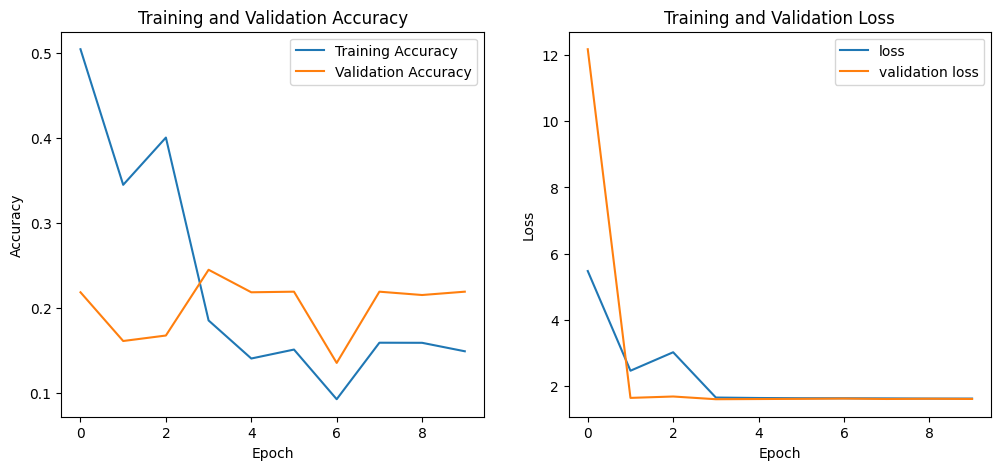

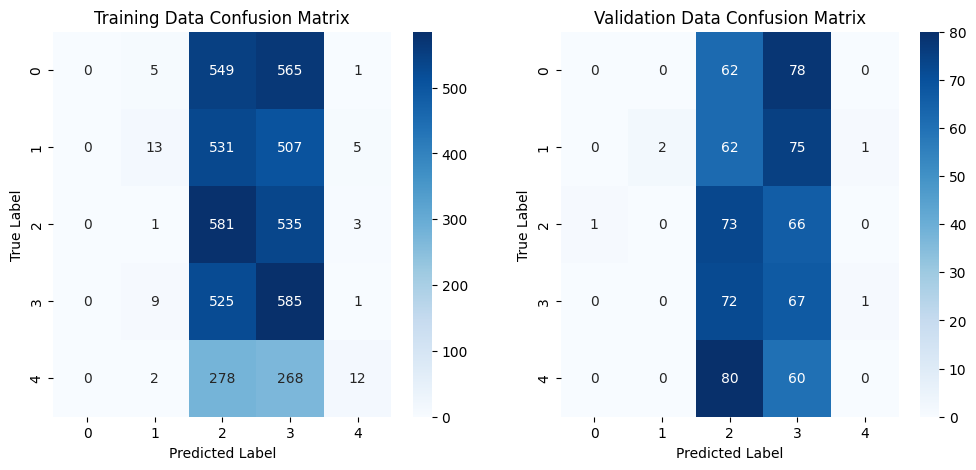

In [ ]:
# Save model files
model3.save('/kaggle/working/model3.h5')
model3.save_weights('/kaggle/working/model3.weights.h5')

# Plot training & validation accuracy values
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history3.history['accuracy'], label='Training Accuracy')
plt.plot(history3.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history3.history['loss'], label='loss')
plt.plot(history3.history['val_loss'], label='validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()


# Calculate confusion matrices for training and validation data
train_conf_matrix, train_class_report = compute_confusion_matrix(model3, train3, steps=5000 // 32)
val_conf_matrix, val_class_report = compute_confusion_matrix(model3, val_dataset_bal.batch(32), steps=1250 // 32)

# Plot confusion matrices
plt.figure(figsize=(12,5))
plt.subplot(1, 2, 1)
sns.heatmap(train_conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Training Data Confusion Matrix')

plt.subplot(1, 2, 2)
sns.heatmap(val_conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Validation Data Confusion Matrix')
plt.show()


# Display raw accuracy values
#history3.history

## Model 3 Analysis:
- We're still seeing similar validation accuracy results but this time the predictions shifted to levels 2 and 3.

# Model 4 Architecture:
- In this model, we'll add batch normalization layers to stabilize and accelerate training. We'll also add in callbacks for learning rate scheduling and early stopping. We'll need these last two features to prevent overfitting since we're also increasing the number of epochs to 50.



- Augmentations:
    - Horizontal flip
    - Vertical flip
- Model Definition:
    - Input Layer: 88x132x3
    - Convolution Layer 1: 32 filters, 3x3 kernel, ReLU activation
    - Batch Normalization Layer 1
    - MaxPooling Layer 1: 2x2 pooling
    - Convolution Layer 2: 64 filters, 3x3 kernel, ReLU activation
    - Batch Normalization Layer 2
    - MaxPooling Layer 2: 2x2 pooling
    - Convolution Layer 3: 128 filters, 3x3 kernel, ReLU activation
    - Batch Normalization Layer 3
    - MaxPooling Layer 3: 2x2 pooling
    - Flatten Layer: Converts the 3D feature maps to 1D feature vector
    - Dense Layer 1: 256 units, ReLU activation
    - Dropout Layer 1: 50% dropout for regularization
    - Dense Layer 2: 128 units, ReLU activation
    - Dropout Layer 2: 50% dropout for regularization
    - Output Layer: 5 units, softmax activation for multi-class classification
- Model Compilation:
    - Optimizer: Adam with learning rate 0.001
    - Loss Function: Sparse Categorical Crossentropy
    - Metrics: Accuracy
- Model Training:
    - Epochs: 50
    - Steps per Epoch: 5000 / 32
    - Validation Steps: 1250 / 32
    - Class Weights: Applied to handle class imbalance
    - Callbacks: Learning rate scheduler, Early stopping

In [ ]:
# Reload train_dataset and split
#train_data, val_data = split_dataset(train_dataset)

# Define data augmentation using TensorFlow functions
def augment_images(image, label):
    # Randomly flip the image horizontally
    image = tf.image.random_flip_left_right(image)
    # Randomly flip the image vertically
    image = tf.image.random_flip_up_down(image)
    return image, label

# Augment train_data and set batch size for both datasets
train4 = train_dataset_bal.map(augment_images).batch(32).repeat()
val4 = val_dataset_bal.batch(32).repeat()

# Display the image shape for training and validation datasets
#display_image_shapes(train4)
#display_image_shapes(val4)

In [ ]:
# Define a learning rate scheduler
def lr_schedule(epoch):
    initial_lr = 0.001
    drop = 0.5
    epochs_drop = 5
    lr = initial_lr * (drop ** (epoch // epochs_drop))
    return lr

# Instantiate lr_scheduler
lr_scheduler = LearningRateScheduler(lr_schedule)

# Early stopping to prevent overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=10)

In [ ]:
# Enable dual-GPU processing for TensorFlow
strategy = tf.distribute.MirroredStrategy()
with strategy.scope():

    # Define the model with batch normalization
    model4 = tf.keras.Sequential([
        tf.keras.layers.InputLayer(input_shape=(88, 132, 3)),
        tf.keras.layers.Conv2D(32, (3, 3), activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPooling2D(2, 2),
        tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPooling2D(2, 2),
        tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPooling2D(2, 2),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(256, activation='relu'),
        tf.keras.layers.Dropout(0.5),  # Add dropout for regularization
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dropout(0.5),  # Add another dropout layer
        tf.keras.layers.Dense(5, activation='softmax')
    ])

    # Compile the model
    model4.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Display model summary
model4.summary()

/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/input_layer.py:25: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_8 (Conv2D)               │ (None, 86, 130, 32)    │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 86, 130, 32)    │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 43, 65, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 41, 63, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 41, 63, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_9 (MaxPooling2D)  │ (None, 20, 31, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 18, 29, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 18, 29, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_10 (MaxPooling2D) │ (None, 9, 14, 128)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 16128)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 256)            │     4,129,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 5)              │           645 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,256,709 (16.24 MB)

 Trainable params: 4,256,261 (16.24 MB)

 Non-trainable params: 448 (1.75 KB)

In [ ]:
# Train the model
history4 = model4.fit(train4,
                      validation_data=val4,
                      epochs=50,
                      steps_per_epoch=5000 // 32,
                      validation_steps=1250 // 32,
                      class_weight=class_weights_dict,
                      callbacks=[lr_scheduler, early_stopping])

Epoch 1/50
156/156 ━━━━━━━━━━━━━━━━━━━━ 47s 291ms/step - accuracy: 0.7141 - loss: 20.1215 - val_accuracy: 0.2170 - val_loss: 43.7381 - learning_rate: 0.0010
Epoch 2/50
156/156 ━━━━━━━━━━━━━━━━━━━━ 45s 291ms/step - accuracy: 0.4461 - loss: 10.6693 - val_accuracy: 0.2323 - val_loss: 1.6559 - learning_rate: 0.0010
Epoch 3/50
156/156 ━━━━━━━━━━━━━━━━━━━━ 45s 288ms/step - accuracy: 0.1294 - loss: 1.7731 - val_accuracy: 0.1935 - val_loss: 1.7138 - learning_rate: 0.0010
Epoch 4/50
156/156 ━━━━━━━━━━━━━━━━━━━━ 45s 291ms/step - accuracy: 0.0974 - loss: 1.6899 - val_accuracy: 0.1952 - val_loss: 1.6202 - learning_rate: 0.0010
Epoch 5/50
156/156 ━━━━━━━━━━━━━━━━━━━━ 45s 290ms/step - accuracy: 0.0657 - loss: 1.6290 - val_accuracy: 0.2154 - val_loss: 1.6052 - learning_rate: 0.0010
Epoch 6/50
156/156 ━━━━━━━━━━━━━━━━━━━━ 45s 292ms/step - accuracy: 0.0977 - loss: 1.6220 - val_accuracy: 0.2242 - val_loss: 1.6029 - learning_rate: 5.0000e-04
Epoch 7/50
156/156 ━━━━━━━━━━━━━━━━━━━━ 45s 291ms/step - accura

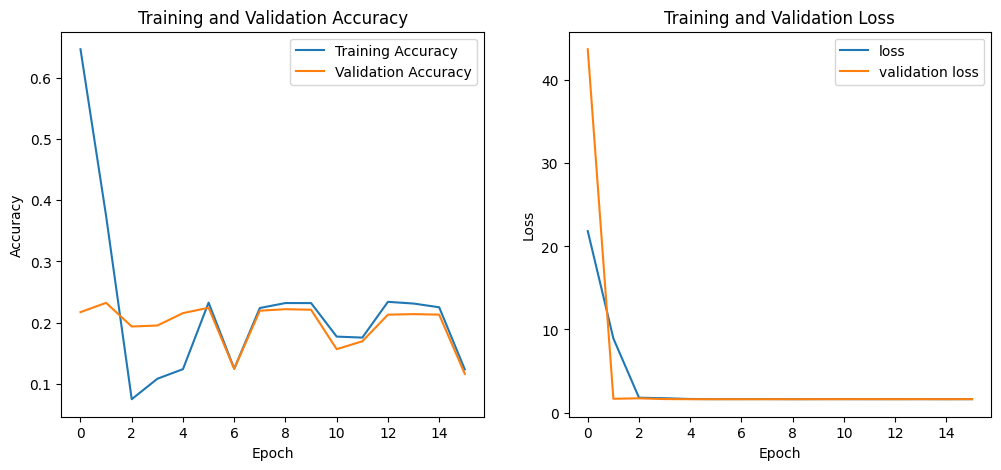

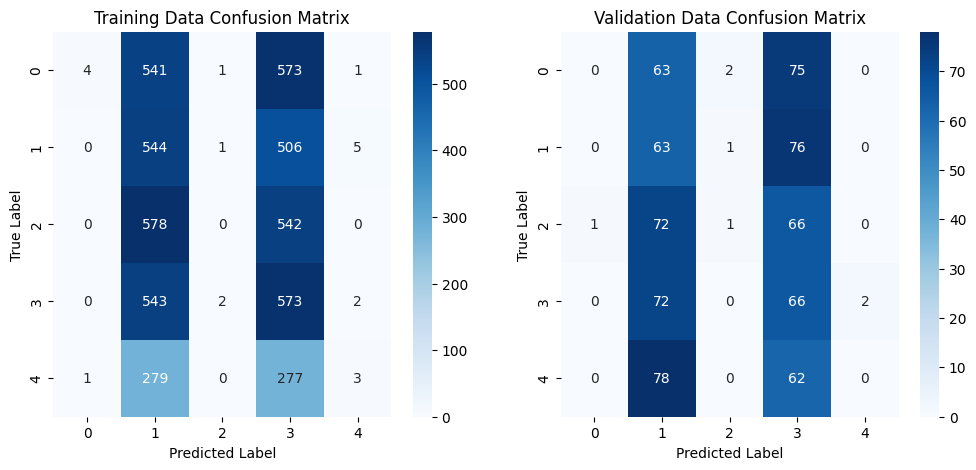

In [ ]:
# Save model files
model4.save('/kaggle/working/model4.h5')
model4.save_weights('/kaggle/working/model4.weights.h5')

# Plot training & validation accuracy values
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history4.history['accuracy'], label='Training Accuracy')
plt.plot(history4.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history4.history['loss'], label='loss')
plt.plot(history4.history['val_loss'], label='validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()


# Calculate confusion matrices for training and validation data
train_conf_matrix, train_class_report = compute_confusion_matrix(model4, train4, steps=5000 // 32)
val_conf_matrix, val_class_report = compute_confusion_matrix(model4, val_dataset_bal.batch(32), steps=1250 // 32)

# Plot confusion matrices
plt.figure(figsize=(12,5))
plt.subplot(1, 2, 1)
sns.heatmap(train_conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Training Data Confusion Matrix')

plt.subplot(1, 2, 2)
sns.heatmap(val_conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Validation Data Confusion Matrix')
plt.show()


# Display raw accuracy values
#history4.history

## Model 4 Analysis:
- Again, similar validation accuracy but this time the predictions split to levels 1 and 3. These basic models just aren't doing the job, so next, we'll bring in some pre-trained model architecture.

# Model 5 Architecture:
- The original convolution layer will be replaced with a pre-trained VGG16 model, excluding the top layers. VGG16 is a Convolution Neural Network architecture, pre-trained on the ImageNet dataset, and known for its simplicity and effectiveness. It consists of 16 layers and is designed specifically for classifying images. We'll also introduce global average pooling to assist with the feature extraction.


- Augmentations:
    - Horizontal flip
    - Vertical flip
    - Random brightness adjustments
    - Random contrast adjustments
- Model Definition:
    - Base Model: VGG16 pre-trained on ImageNet, input shape 88x132x3, include top layers as False
    - Global Average Pooling Layer: Converts the 3D feature maps to 1D feature vector
    - Dense Layer 1: 256 units, ReLU activation
    - Dropout Layer 1: 50% dropout for regularization
    - Dense Layer 2: 128 units, ReLU activation
    - Dropout Layer 2: 50% dropout for regularization
    - Output Layer: 5 units, softmax activation for multi-class classification
- Model Compilation:
    - Optimizer: Adam with learning rate 0.001
    - Loss Function: Sparse Categorical Crossentropy
    - Metrics: Accuracy
- Model Training:
    - Epochs: 50
    - Steps per Epoch: 5000 / 32
    - Validation Steps: 1250 / 32
    - Class Weights: Applied to handle class imbalance
    - Callbacks: Learning rate scheduler, Early stopping

In [ ]:
# Reload train_dataset and split
#train_data, val_data = split_dataset(train_dataset)

# Define data augmentation using TensorFlow functions
def augment_images(image, label):
    # Randomly flip the image horizontally
    image = tf.image.random_flip_left_right(image)
    # Randomly flip the image vertically
    image = tf.image.random_flip_up_down(image)
    # Randomly change the brightness of the image
    image = tf.image.random_brightness(image, max_delta=0.3)
    # Randomly change the contrast of the image
    image = tf.image.random_contrast(image, lower=0.8, upper=1.2)
    return image, label

# Augment train_data and set batch size for both datasets
train5 = train_dataset_bal.map(augment_images).batch(32).repeat()
val5 = val_dataset_bal.batch(32).repeat()

# Define a learning rate scheduler
def lr_schedule(epoch):
    initial_lr = 0.001
    drop = 0.5
    epochs_drop = 5
    lr = initial_lr * (drop ** (epoch // epochs_drop))
    return lr

# Instantiate lr_scheduler
lr_scheduler = LearningRateScheduler(lr_schedule)

# Early stopping to prevent overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=10)

# Enable dual-GPU processing for TensorFlow
strategy = tf.distribute.MirroredStrategy()
with strategy.scope():
    # Define the model using transfer learning
    base_model = VGG16(input_shape=(88, 132, 3), include_top=False, weights='imagenet')
    base_model.trainable = False  # Freeze the base model

    # Define the model
    model5 = tf.keras.Sequential([
        base_model,
        GlobalAveragePooling2D(),  # Use GlobalAveragePooling2D instead of Flatten
        Dense(256, activation='relu'),
        Dropout(0.5),
        Dense(128, activation='relu'),
        Dropout(0.5),
        Dense(5, activation='softmax')
    ])

    # Compile the model
    model5.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

# Display model summary
model5.summary()

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)              │ ?                      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ ?                      │   0 (unbuilt) │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 14,714,688 (56.13 MB)

In [ ]:
# Train the model
history5 = model5.fit(train5,
                      validation_data=val5,
                      epochs=50,
                      steps_per_epoch=5000 // 32,
                      validation_steps=1250 // 32,
                      class_weight=class_weights_dict,
                      callbacks=[lr_scheduler, early_stopping])

Epoch 1/50
156/156 ━━━━━━━━━━━━━━━━━━━━ 56s 287ms/step - accuracy: 0.4330 - loss: 9.3880 - val_accuracy: 0.2524 - val_loss: 1.9145 - learning_rate: 0.0010
Epoch 2/50
156/156 ━━━━━━━━━━━━━━━━━━━━ 32s 207ms/step - accuracy: 0.1343 - loss: 1.9948 - val_accuracy: 0.2629 - val_loss: 1.6059 - learning_rate: 0.0010
Epoch 3/50
156/156 ━━━━━━━━━━━━━━━━━━━━ 33s 210ms/step - accuracy: 0.0985 - loss: 1.6453 - val_accuracy: 0.2710 - val_loss: 1.6037 - learning_rate: 0.0010
Epoch 4/50
156/156 ━━━━━━━━━━━━━━━━━━━━ 33s 210ms/step - accuracy: 0.0994 - loss: 1.6807 - val_accuracy: 0.2000 - val_loss: 1.5960 - learning_rate: 0.0010
Epoch 5/50
156/156 ━━━━━━━━━━━━━━━━━━━━ 33s 209ms/step - accuracy: 0.1342 - loss: 1.6553 - val_accuracy: 0.1945 - val_loss: 1.6099 - learning_rate: 0.0010
Epoch 6/50
156/156 ━━━━━━━━━━━━━━━━━━━━ 33s 210ms/step - accuracy: 0.2161 - loss: 1.6016 - val_accuracy: 0.2726 - val_loss: 1.5972 - learning_rate: 5.0000e-04
Epoch 7/50
156/156 ━━━━━━━━━━━━━━━━━━━━ 32s 207ms/step - accuracy:

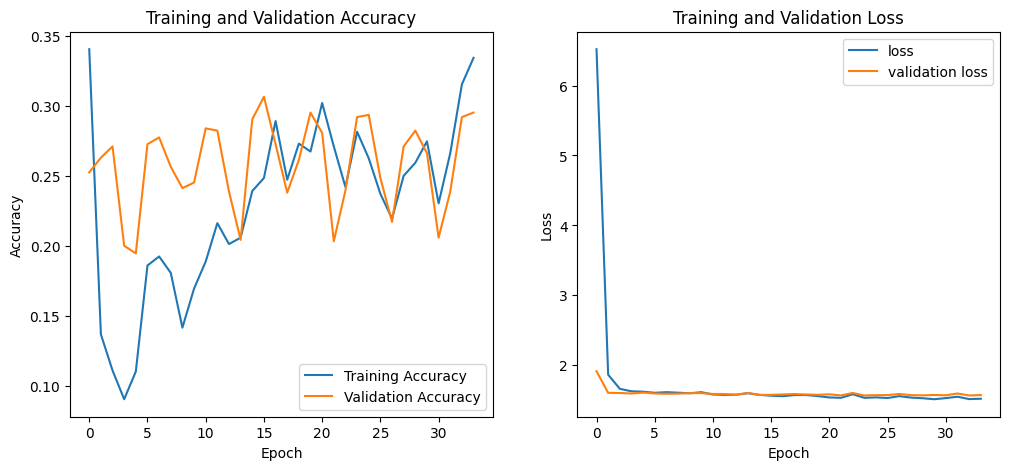

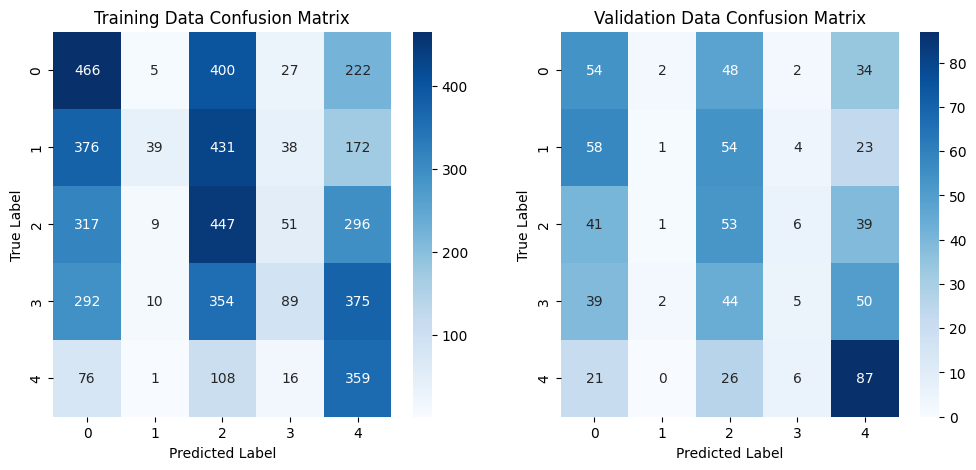

In [ ]:
# Save model files
model5.save('/kaggle/working/model5.h5')
model5.save_weights('/kaggle/working/model5.weights.h5')

# Plot training & validation accuracy values
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history5.history['accuracy'], label='Training Accuracy')
plt.plot(history5.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history5.history['loss'], label='loss')
plt.plot(history5.history['val_loss'], label='validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()


# Calculate confusion matrices for training and validation data
train_conf_matrix, train_class_report = compute_confusion_matrix(model5, train5, steps=5000 // 32)
val_conf_matrix, val_class_report = compute_confusion_matrix(model5, val_dataset_bal.batch(32), steps=1250 // 32)

# Plot confusion matrices
plt.figure(figsize=(12,5))
plt.subplot(1, 2, 1)
sns.heatmap(train_conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Training Data Confusion Matrix')

plt.subplot(1, 2, 2)
sns.heatmap(val_conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Validation Data Confusion Matrix')
plt.show()


# Display raw accuracy values
#history5.history

## Model 5 Analysis:
- With the addition of the VGG16 model, our accuracy jumped 5% and our predictions are more widespread. This still isn't great performance, so let's run the same model again to see if we can enhance its performance.

# Model 6 Architecture:
- This is simply a repeat of Model 5 in an attempt to improve robustness of the training.



- Augmentations:
    - Horizontal flip
    - Vertical flip
    - Random brightness adjustments
    - Random contrast adjustments
- Model Definition:
    - Base Model: VGG16 pre-trained on ImageNet, input shape 88x132x3, include top layers as False
    - Global Average Pooling Layer: Converts the 3D feature maps to 1D feature vector
    - Dense Layer 1: 256 units, ReLU activation
    - Dropout Layer 1: 50% dropout for regularization
    - Dense Layer 2: 128 units, ReLU activation
    - Dropout Layer 2: 50% dropout for regularization
    - Output Layer: 5 units, softmax activation for multi-class classification
- Model Compilation:
    - Optimizer: Adam with learning rate 0.001
    - Loss Function: Sparse Categorical Crossentropy
    - Metrics: Accuracy
- Model Training:
    - Epochs: 50
    - Steps per Epoch: 5000 / 32
    - Validation Steps: 1250 / 32
    - Class Weights: Applied to handle class imbalance
    - Callbacks: Learning rate scheduler, Early stopping

In [ ]:
# Reload train_dataset and split
#train_data, val_data = split_dataset(train_dataset)

# Define data augmentation using TensorFlow functions
def augment_images(image, label):
    # Randomly flip the image horizontally
    image = tf.image.random_flip_left_right(image)
    # Randomly flip the image vertically
    image = tf.image.random_flip_up_down(image)
    # Randomly change the brightness of the image
    image = tf.image.random_brightness(image, max_delta=0.3)
    # Randomly change the contrast of the image
    image = tf.image.random_contrast(image, lower=0.8, upper=1.2)
    return image, label

# Augment train_data and set batch size for both datasets
train6 = train_dataset_bal.map(augment_images, num_parallel_calls=tf.data.experimental.AUTOTUNE).batch(32).repeat()
val6 = val_dataset_bal.batch(32).repeat()

# Define a learning rate scheduler
def lr_schedule(epoch):
    initial_lr = 0.001
    drop = 0.5
    epochs_drop = 5
    lr = initial_lr * (drop ** (epoch // epochs_drop))
    return lr

# Instantiate lr_scheduler
lr_scheduler = LearningRateScheduler(lr_schedule)

# Early stopping to prevent overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=10)

# Enable dual-GPU processing for TensorFlow
strategy = tf.distribute.MirroredStrategy()
with strategy.scope():
    # Define the model using transfer learning
    base_model = VGG16(input_shape=(88, 132, 3), include_top=False, weights='imagenet')
    base_model.trainable = False  # Freeze the base model

    # Define the model
    model6 = tf.keras.Sequential([
        base_model,
        GlobalAveragePooling2D(),  # Use GlobalAveragePooling2D instead of Flatten
        Dense(256, activation='relu'),
        Dropout(0.5),
        Dense(128, activation='relu'),
        Dropout(0.5),
        Dense(5, activation='softmax')
    ])

    model6.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
                   loss='sparse_categorical_crossentropy',
                   metrics=['accuracy'])

model6.summary()

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)              │ ?                      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ ?                      │   0 (unbuilt) │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 14,714,688 (56.13 MB)

In [ ]:
# Train the model
history6 = model6.fit(train6,
                      validation_data=val6,
                      epochs=50,
                      steps_per_epoch=5000 // 32,
                      validation_steps=1250 // 32,
                      class_weight=class_weights_dict,
                      callbacks=[lr_scheduler, early_stopping])

Epoch 1/50
156/156 ━━━━━━━━━━━━━━━━━━━━ 33s 209ms/step - accuracy: 0.4845 - loss: 8.8150 - val_accuracy: 0.2395 - val_loss: 1.6027 - learning_rate: 0.0010
Epoch 2/50
156/156 ━━━━━━━━━━━━━━━━━━━━ 32s 208ms/step - accuracy: 0.1454 - loss: 1.8527 - val_accuracy: 0.2226 - val_loss: 1.5968 - learning_rate: 0.0010
Epoch 3/50
156/156 ━━━━━━━━━━━━━━━━━━━━ 32s 207ms/step - accuracy: 0.1390 - loss: 1.6667 - val_accuracy: 0.2565 - val_loss: 1.5924 - learning_rate: 0.0010
Epoch 4/50
156/156 ━━━━━━━━━━━━━━━━━━━━ 32s 208ms/step - accuracy: 0.0743 - loss: 1.6320 - val_accuracy: 0.2532 - val_loss: 1.5870 - learning_rate: 0.0010
Epoch 5/50
156/156 ━━━━━━━━━━━━━━━━━━━━ 32s 206ms/step - accuracy: 0.0832 - loss: 1.6367 - val_accuracy: 0.1929 - val_loss: 1.6089 - learning_rate: 0.0010
Epoch 6/50
156/156 ━━━━━━━━━━━━━━━━━━━━ 32s 208ms/step - accuracy: 0.1228 - loss: 1.6067 - val_accuracy: 0.2290 - val_loss: 1.5868 - learning_rate: 5.0000e-04
Epoch 7/50
156/156 ━━━━━━━━━━━━━━━━━━━━ 32s 207ms/step - accuracy:

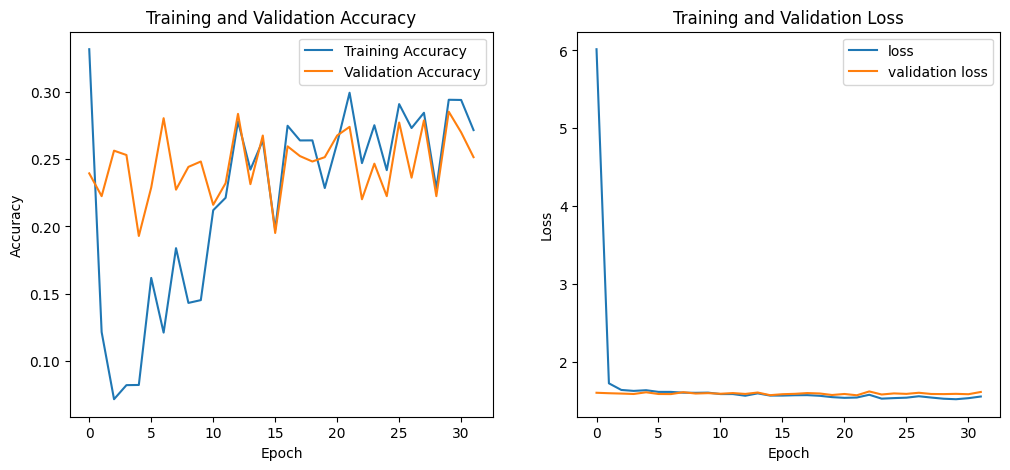

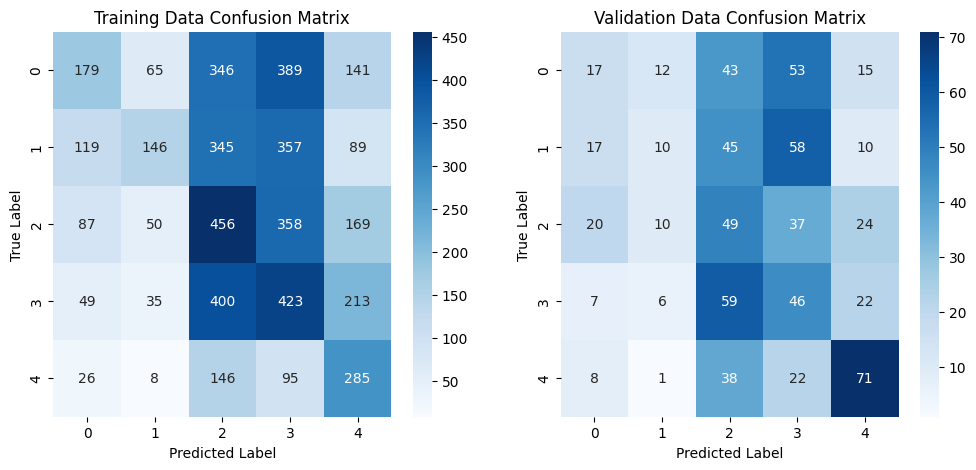

In [ ]:
# Save model files
model6.save('/kaggle/working/model6.h5')
model6.save_weights('/kaggle/working/model6.weights.h5')

# Plot training & validation accuracy values
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history6.history['accuracy'], label='Training Accuracy')
plt.plot(history6.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history6.history['loss'], label='loss')
plt.plot(history6.history['val_loss'], label='validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()


# Calculate confusion matrices for training and validation data
train_conf_matrix, train_class_report = compute_confusion_matrix(model6, train6, steps=5000 // 32)
val_conf_matrix, val_class_report = compute_confusion_matrix(model6, val_dataset_bal.batch(32), steps=1250 // 32)

# Plot confusion matrices
plt.figure(figsize=(12,5))
plt.subplot(1, 2, 1)
sns.heatmap(train_conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Training Data Confusion Matrix')

plt.subplot(1, 2, 2)
sns.heatmap(val_conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Validation Data Confusion Matrix')
plt.show()


# Display raw accuracy values
#history6.history

## Model 6 Analysis
- Similar results to Model 5 with even more widespread predictions. We've seen the benefits of importing pre-trained models, so let's try another option.

# Model 7 Architecture
- In this model, we'll exchange the VGG16 layer for EfficientNetB0 which provides more efficient and powerful feature extraction due to EfficientNet's optimized architecture. The dense layers were also increased to better utilize the features extracted by EfficientNetB0.



- Augmentations:
    - Horizontal flip
    - Vertical flip
    - Random brightness adjustments
    - Random contrast adjustments
- Model Definition:
    - Base Model: EfficientNetB0 pre-trained on ImageNet, input shape 88x132x3, include top layers as False
    - Global Average Pooling Layer: Converts the 3D feature maps to 1D feature vector
    - Dense Layer 1: 512 units, ReLU activation
    - Dropout Layer 1: 50% dropout for regularization
    - Dense Layer 2: 256 units, ReLU activation
    - Dropout Layer 2: 50% dropout for regularization
    - Output Layer: 5 units, softmax activation for multi-class classification
- Model Compilation:
    - Optimizer: Adam with learning rate 0.001
    - Loss Function: Sparse Categorical Crossentropy
    - Metrics: Accuracy
- Model Training:
    - Epochs: 50
    - Steps per Epoch: 5000 / 32
    - Validation Steps: 1250 / 32
    - Class Weights: Applied to handle class imbalance
    - Callbacks: Learning rate scheduler, Early stopping

In [ ]:
# Define data augmentation using TensorFlow functions
def augment_images(image, label):
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_flip_up_down(image)
    image = tf.image.random_brightness(image, max_delta=0.3)
    image = tf.image.random_contrast(image, lower=0.8, upper=1.2)
    return image, label

# Augment train_data and set batch size for both datasets
train7 = train_dataset_bal.map(augment_images).batch(32).repeat()
val7 = val_dataset_bal.batch(32).repeat()

# Define a learning rate scheduler
def lr_schedule(epoch):
    initial_lr = 0.001
    drop = 0.5
    epochs_drop = 5
    lr = initial_lr * (drop ** (epoch // epochs_drop))
    return lr

# Instantiate lr_scheduler
lr_scheduler = LearningRateScheduler(lr_schedule)

# Early stopping to prevent overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=10)

# Enable dual-GPU processing for TensorFlow
strategy = tf.distribute.MirroredStrategy()
with strategy.scope():
    # Define the model using EfficientNetB0
    base_model = EfficientNetB0(input_shape=(88, 132, 3), include_top=False, weights='imagenet')
    base_model.trainable = False  # Freeze the base model

    model7 = tf.keras.Sequential([
        base_model,
        GlobalAveragePooling2D(),  # Use GlobalAveragePooling2D instead of Flatten
        Dense(512, activation='relu'),
        Dropout(0.5),
        Dense(256, activation='relu'),
        Dropout(0.5),
        Dense(5, activation='softmax')
    ])

    model7.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
                   loss='sparse_categorical_crossentropy',
                   metrics=['accuracy'])

model7.summary()

16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ efficientnetb0 (Functional)     │ ?                      │     4,049,571 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_2      │ ?                      │   0 (unbuilt) │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_18 (Dense)                │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_19 (Dense)                │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,049,571 (15.45 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 4,049,571 (15.45 MB)

In [ ]:
# Train the model
history7 = model7.fit(train7,
                      validation_data=val7,
                      epochs=50,
                      steps_per_epoch=5000 // 32,
                      validation_steps=1250 // 32,
                      class_weight=class_weights_dict,
                      callbacks=[lr_scheduler, early_stopping])

Epoch 1/50
156/156 ━━━━━━━━━━━━━━━━━━━━ 214s 1s/step - accuracy: 0.5425 - loss: 3.0546 - val_accuracy: 0.2154 - val_loss: 1.6390 - learning_rate: 0.0010
Epoch 2/50
156/156 ━━━━━━━━━━━━━━━━━━━━ 210s 1s/step - accuracy: 0.1823 - loss: 1.7567 - val_accuracy: 0.2226 - val_loss: 1.6072 - learning_rate: 0.0010
Epoch 3/50
156/156 ━━━━━━━━━━━━━━━━━━━━ 208s 1s/step - accuracy: 0.1764 - loss: 1.6979 - val_accuracy: 0.2387 - val_loss: 1.6241 - learning_rate: 0.0010
Epoch 4/50
156/156 ━━━━━━━━━━━━━━━━━━━━ 209s 1s/step - accuracy: 0.2201 - loss: 1.6314 - val_accuracy: 0.2065 - val_loss: 1.6036 - learning_rate: 0.0010
Epoch 5/50
156/156 ━━━━━━━━━━━━━━━━━━━━ 209s 1s/step - accuracy: 0.0792 - loss: 1.6933 - val_accuracy: 0.1254 - val_loss: 1.6127 - learning_rate: 0.0010
Epoch 6/50
156/156 ━━━━━━━━━━━━━━━━━━━━ 210s 1s/step - accuracy: 0.2014 - loss: 1.6337 - val_accuracy: 0.2194 - val_loss: 3.3305 - learning_rate: 5.0000e-04
Epoch 7/50
156/156 ━━━━━━━━━━━━━━━━━━━━ 209s 1s/step - accuracy: 0.1990 - loss

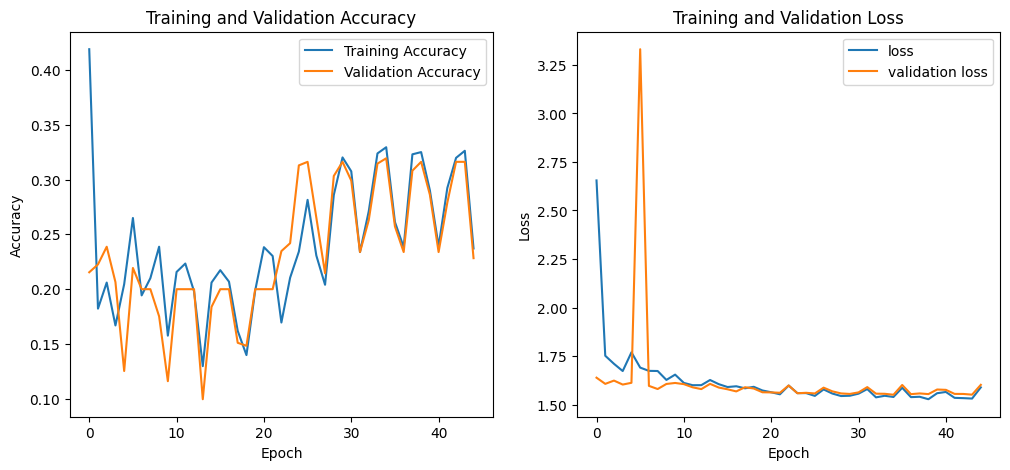

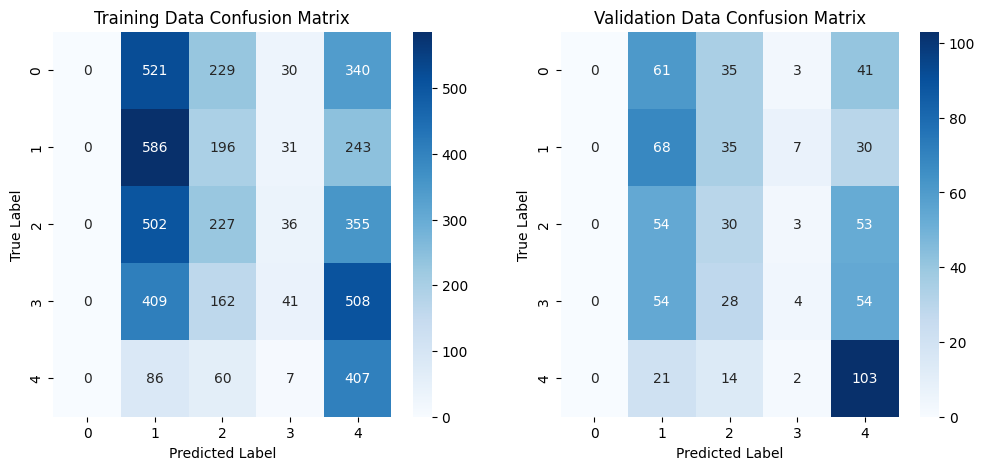

In [ ]:
# Save model files
model7.save('/kaggle/working/model7.h5')
model7.save_weights('/kaggle/working/model7.weights.h5')

# Plot training & validation accuracy values
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history7.history['accuracy'], label='Training Accuracy')
plt.plot(history7.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history7.history['loss'], label='loss')
plt.plot(history7.history['val_loss'], label='validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Calculate confusion matrices for training and validation data
train_conf_matrix, train_class_report = compute_confusion_matrix(model7, train7, steps=5000 // 32)
val_conf_matrix, val_class_report = compute_confusion_matrix(model7, val_dataset_bal.batch(32), steps=1250 // 32)

# Plot confusion matrices
plt.figure(figsize=(12,5))
plt.subplot(1, 2, 1)
sns.heatmap(train_conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Training Data Confusion Matrix')

plt.subplot(1, 2, 2)
sns.heatmap(val_conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Validation Data Confusion Matrix')
plt.show()

# Display raw accuracy values
#history7.history

## Model 7 Analysis
- The EfficientNet model gave us much tighter performance between the training and validation accuracies, but we're still not making it past the 30% mark. The prediction labels are also well-spread, but still not accurate.

# Model Training Results
- Let's look at all of the model accuracies once again and determine the best-performing model by average validation accuracy score.

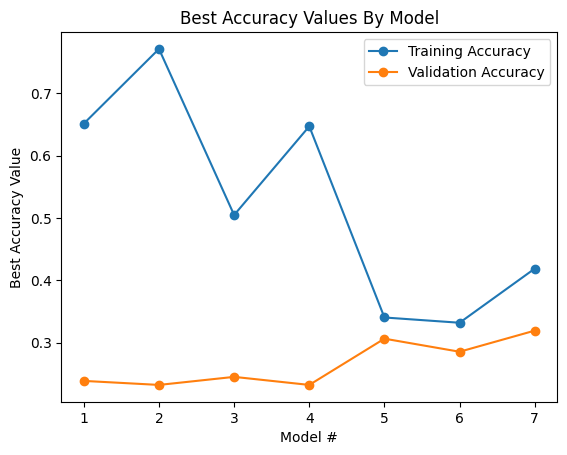

In [ ]:
# Get the best training accuracy for each model
accuracies = [
    max(history1.history["accuracy"]),
    max(history2.history["accuracy"]),
    max(history3.history["accuracy"]),
    max(history4.history["accuracy"]),
    max(history5.history["accuracy"]),
    max(history6.history["accuracy"]),
    max(history7.history["accuracy"])
]

# Get the best val_accuracy for each model
val_accuracies = [
    max(history1.history["val_accuracy"]),
    max(history2.history["val_accuracy"]),
    max(history3.history["val_accuracy"]),
    max(history4.history["val_accuracy"]),
    max(history5.history["val_accuracy"]),
    max(history6.history["val_accuracy"]),
    max(history7.history["val_accuracy"])
]


# Indices for x-axis
indices = range(1, len(accuracies) + 1)

# Plot best accuracy values for each model
plt.plot(indices, accuracies, label="Training Accuracy", marker='o')
plt.plot(indices, val_accuracies, label="Validation Accuracy", marker='o')
plt.title("Best Accuracy Values By Model")
plt.ylabel("Best Accuracy Value")
plt.xlabel("Model #")
plt.xticks(indices)
plt.legend()
plt.show()

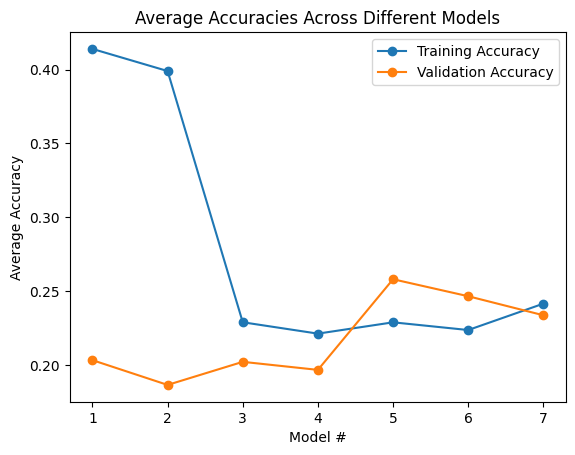

In [ ]:
# Get the average training accuracy for each model
accuracies = [
    np.mean(history1.history["accuracy"]),
    np.mean(history2.history["accuracy"]),
    np.mean(history3.history["accuracy"]),
    np.mean(history4.history["accuracy"]),
    np.mean(history5.history["accuracy"]),
    np.mean(history6.history["accuracy"]),
    np.mean(history7.history["accuracy"])
]

# Get the average val_accuracy for each model
val_accuracies = [
    np.mean(history1.history["val_accuracy"]),
    np.mean(history2.history["val_accuracy"]),
    np.mean(history3.history["val_accuracy"]),
    np.mean(history4.history["val_accuracy"]),
    np.mean(history5.history["val_accuracy"]),
    np.mean(history6.history["val_accuracy"]),
    np.mean(history7.history["val_accuracy"])
]


# Indices for x-axis
indices = range(1, len(accuracies) + 1)

# Plot best accuracy values for each model
plt.plot(indices, accuracies, label="Training Accuracy", marker='o')
plt.plot(indices, val_accuracies, label="Validation Accuracy", marker='o')
plt.title("Average Accuracies Across Different Models")
plt.ylabel("Average Accuracy")
plt.xlabel("Model #")
plt.xticks(indices)
plt.legend()
plt.show()

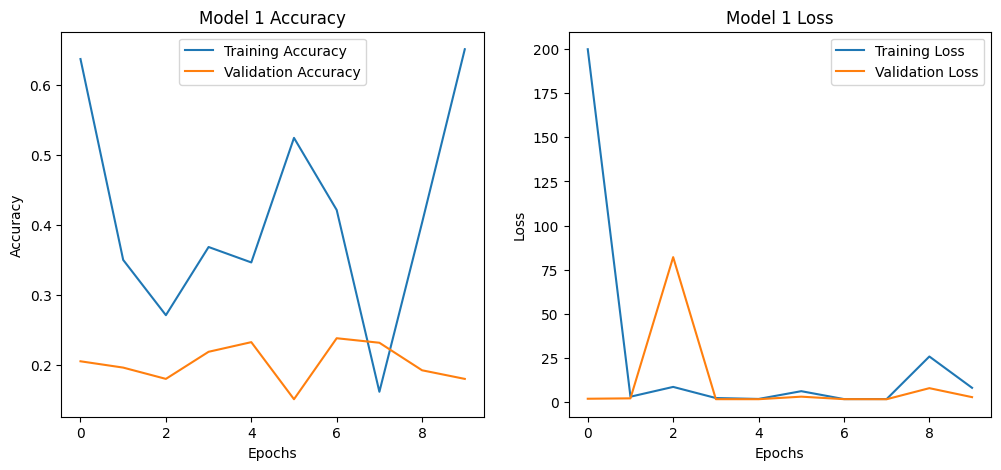

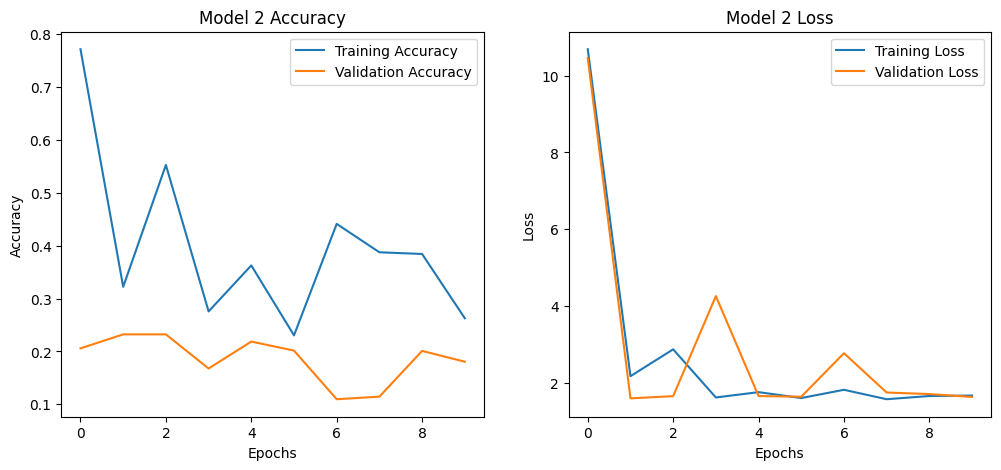

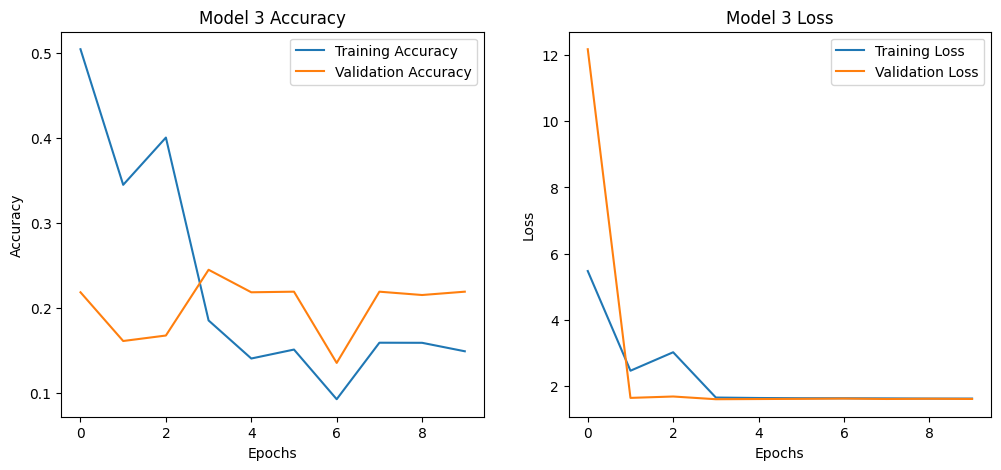

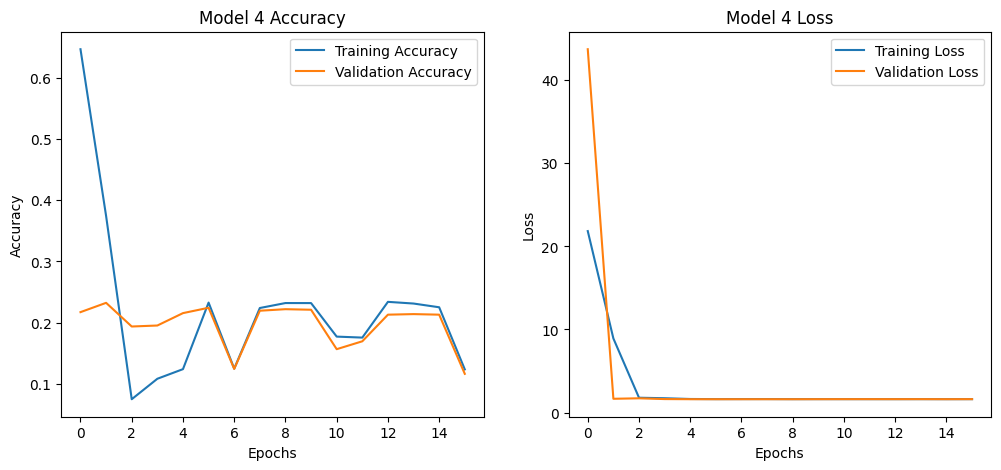

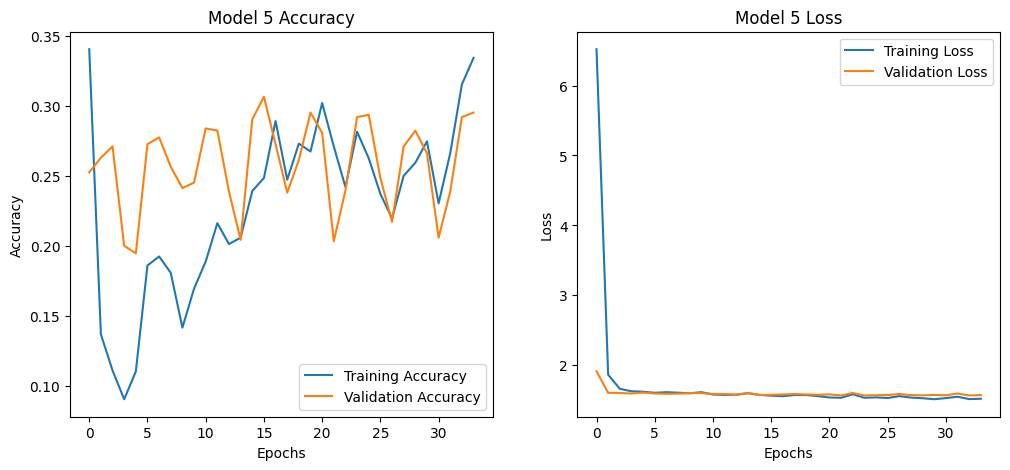

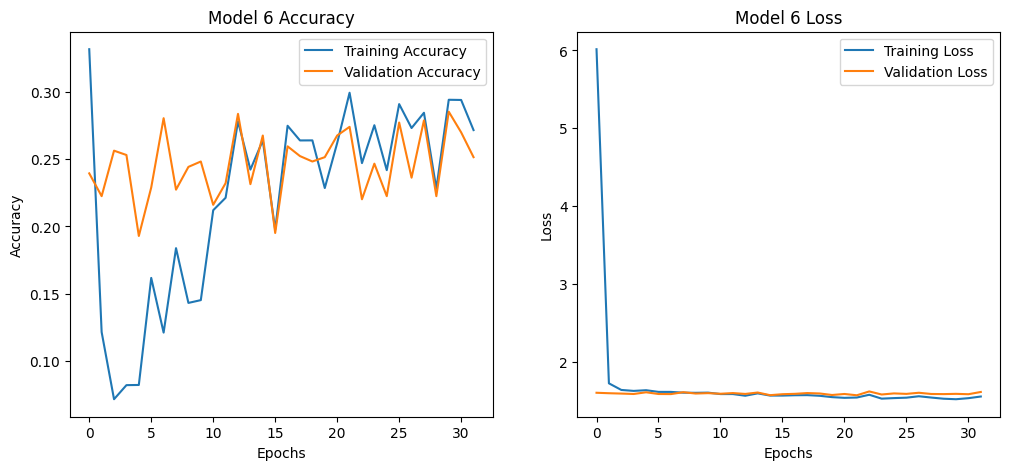

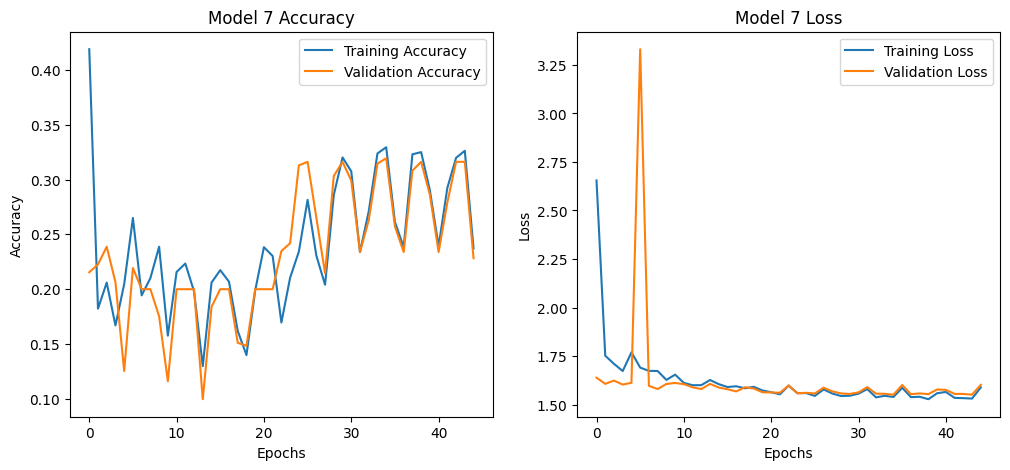

Model 5 has the highest average validation accuracy.


In [ ]:
# Calculate average training and validation accuracies
avg_accuracies = [
    np.mean(history1.history["accuracy"]),
    np.mean(history2.history["accuracy"]),
    np.mean(history3.history["accuracy"]),
    np.mean(history4.history["accuracy"]),
    np.mean(history5.history["accuracy"]),
    np.mean(history6.history["accuracy"]),
    np.mean(history7.history["accuracy"])
]

avg_val_accuracies = [
    np.mean(history1.history["val_accuracy"]),
    np.mean(history2.history["val_accuracy"]),
    np.mean(history3.history["val_accuracy"]),
    np.mean(history4.history["val_accuracy"]),
    np.mean(history5.history["val_accuracy"]),
    np.mean(history6.history["val_accuracy"]),
    np.mean(history7.history["val_accuracy"])
]

# Calculate average validation losses
avg_val_losses = [
    np.mean(history1.history["val_loss"]),
    np.mean(history2.history["val_loss"]),
    np.mean(history3.history["val_loss"]),
    np.mean(history4.history["val_loss"]),
    np.mean(history5.history["val_loss"]),
    np.mean(history6.history["val_loss"]),
    np.mean(history7.history["val_loss"])
]


# Validate for overfitting by comparing training and validation accuracies
#print("Average Training Accuracies:", avg_accuracies)
#print("Average Validation Accuracies:", avg_val_accuracies)
#print("Average Validation Losses:", avg_val_losses)

# Plot accuracies and losses for all models
models = [history1, history2, history3, history4, history5, history6, history7]
for i, history in enumerate(models):
    plt.figure(figsize=(12, 5))

    # Plot accuracy
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title(f'Model {i + 1} Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    # Plot loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title(f'Model {i + 1} Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.show()


# Determine the best model based on validation accuracy
best_model_idx = np.argmax(avg_val_accuracies)
print(f"Model {best_model_idx + 1} has the highest average validation accuracy.")


In [ ]:
# Save the best model name as a string
best_model_name = f'/kaggle/working/model{best_model_idx + 1}.h5'

# Select the best model from the list
best_model = load_model(best_model_name)

# Test Image Prediction
- Having identified our best performing model above, we'll use it to predict the level classifications for our test images.

In [ ]:
# Function to preprocess the test dataset
def preprocess_image(image):
    image = tf.image.resize(image, [88, 132])  # Resize images to 88x132
    image = tf.cast(image, tf.float32) / 255.0  # Normalize to [0, 1]
    return image

# Function to parse the TFRecord file
def parse_tfrecord_fn(example):
    # Define the feature description
    feature_description = {
        'image_raw': tf.io.FixedLenFeature([], tf.string),
        'filename': tf.io.FixedLenFeature([], tf.string)
    }
    # Parse the input tf.train.Example proto using the dictionary above
    example = tf.io.parse_single_example(example, feature_description)
    image = tf.io.decode_raw(example['image_raw'], tf.uint8)
    image = tf.reshape(image, [88, 132, 3])  # Assuming the original shape of the image is known
    filename = example['filename']
    return image, filename

# Load the test dataset
test_files = glob.glob("../input/eyes-full-88x132/test_data_*.tfrecord")
test_dataset = tf.data.TFRecordDataset(test_files)

# Apply parsing and preprocessing to the test dataset
test_dataset = test_dataset.map(parse_tfrecord_fn)
test_dataset = test_dataset.map(lambda image, filename: (preprocess_image(image), filename))

# Verify the dataset length
num_samples = 0
for _ in test_dataset:
    num_samples += 1
print(f'Number of samples in the test dataset: {num_samples}')

# Set up batching for the test data
batch_size = 32
test_dataset = test_dataset.batch(batch_size)

# Calculate the number of steps per epoch
steps_per_epoch = num_samples // batch_size + (num_samples % batch_size != 0)
print(f'Steps per epoch: {steps_per_epoch}')

# Save the best model name as a string
best_model_name = f'/kaggle/working/model{best_model_idx + 1}.h5'

# Select the best model from the list
best_model = load_model(best_model_name)
print(f"Using model {best_model_idx + 1} for predictions.")

# Make predictions
predictions = best_model.predict(test_dataset.map(lambda image, filename: image), steps=steps_per_epoch)

Number of samples in the test dataset: 53576
Steps per epoch: 1675
Using model 5 for predictions.
1675/1675 ━━━━━━━━━━━━━━━━━━━━ 74s 42ms/step


In [ ]:
# Get the predicted class labels
predicted_levels = tf.argmax(predictions[:num_samples], axis=1).numpy()

# Print a summary of the predictions
unique, counts = np.unique(predicted_levels, return_counts=True)
prediction_summary = dict(zip(unique, counts))
print("Prediction summary:", prediction_summary)

# Extract filenames
filenames = []
for batch in test_dataset:
    filenames.extend(batch[1].numpy())

# Decode filenames from bytes to string and remove .jpeg extension
filenames = [filename.decode('utf-8').replace('.jpeg', '') for filename in filenames]

# Ensure the lengths match
assert len(predicted_levels) == len(filenames), "Length mismatch between predictions and filenames"

# Create DataFrame
results = pd.DataFrame({
    'image': filenames,
    'level': predicted_levels
})

# Export to CSV
results.to_csv('test_predictions.csv', index=False)

# Show the results dataframe to ensure correct formatting
results.head()

print("Predictions saved to 'test_predictions.csv'")

Prediction summary: {3: 53005, 4: 571}
Predictions saved to 'test_predictions.csv'


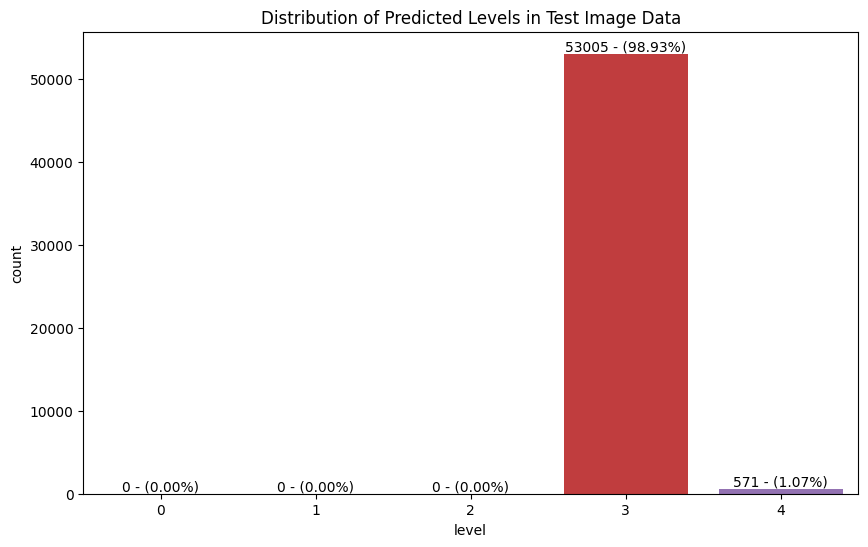

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt


# Calculate the count and percentage of each label
label_counts = results['level'].value_counts()
total_count = len(results)
label_percentages = (label_counts / total_count) * 100

# Ensure all levels (0 to 4) are represented in the DataFrame
all_levels = pd.Series(range(5), name='level')
label_info = pd.DataFrame({'level': all_levels}).set_index('level')
label_info['count'] = label_counts
label_info['percentage'] = label_percentages
label_info = label_info.fillna(0)

# Print the label info and the unique levels to debug
#print("Label info:", label_info)
#print("Unique levels in results:", results['level'].unique())

# Plot the label distribution
plt.figure(figsize=(10, 6))
ax = sns.countplot(x='level', data=results, order=all_levels)
plt.title("Distribution of Predicted Levels in Test Image Data")

# Annotate with counts and percentages
for p in ax.patches:
    height = p.get_height()
    level = int(p.get_x() + p.get_width() / 2.0)
    count = label_info.loc[level, 'count']
    percentage = label_info.loc[level, 'percentage']
    ax.annotate(f'{count:.0f} - ({percentage:.2f}%)', (p.get_x() + p.get_width() / 2., height),
                ha='center', va='bottom')

plt.show()


# Results and Analysis
- Through seven iterations of model architecture, we were able to achieve only moderate accuracy on the validation data. Even adjusting the model training for class weights and ultimately building a fully balanced training dataset, the best of our models only hit the 25% mark for accuracy. Also, based on the confusion matrices, we never established a useful predictive accuracy for the validation images.
- Pulling in external, pre-trained resources such as VGG or EfficientNet did bring our accuracy up 5%, but in the end, even our best model failed to classify the test images with any reasonable distribution.
- In terms of the Kaggle Competition, after submitting my results, I achieved an embarassing 0.00099.

# Conclusion
- Convolution Neural Networks (CNNs) are a powerful image procesing tool. In this project, each layer of the CNN learned to recognize various features from each image. By detecting small features like blood vessels or more complex structures like retinal hemorrhages, the layers combined to identify high-level features representing symptoms of Diabetic Retinopathy.
In an earlier version of this code, I was much more optimistic when the validation accuracy numbers were coming in at 70-80%. However, once I applied those models to the test data, I quickly realized that everything was being classified as 0 since those images comprised the vast majority of the training data. This was all due to the unbalanced distribution of image classes, where over 70% of the training images were Level 0.
- Ultimately, the balance of classifications for the test data indicates the inherent challenges in identifying various retina scan features. Due mostly to my limited experience implementing CNN architectures, I was unable to create a model that could accurately predict Diabetic Retinopathy symptoms with any level of credible accuracy. With so much variance and noise in the training images, the models were not able to find the significant features and patterns that an experienced ophthalmologist might be able to work around.

- Interesting findings:
    - Most models classify the validation data at just one level. I'm curious to know the patterns in the images that caused this.
    - I decided to submit one of my previous prediction files, which had almost all images classified as level 0. That one scored 0.01158 on the Kaggle site. I'm still embarrassed.

- Future ideas and improvements:
    - Finding a larger, BALANCED dataset would likely provide the scale of variety necessary to properly train CNN models.
    - Implementing feature mapping techniques may go a long way in improving the accuracies. Feature Mapping would add additional layers to the model that focus on specific segments of an image that may be a stronger indicator of Diabetic Retinopathy than others.
    - Another idea might be to change the dataset and models to binary classification, testing to see whether any kind of Diabetic Retinopathy symptoms are present or not. As stated before, 93 million of the global population is known to have some symptoms of this eye disease. A binary model that would help identify whether or not someone should seek further treatment could be very beneficial to the 1% or the human population affected by Diabetic Retinopathy.
    




## Reference

[1] Diabetic Retinopathy Detection
- Emma Dugas, Jared, Jorge, Will Cukierski
- "Diabetic Retinopathy Detection," 2015
- https://www.kaggle.com/competitions/diabetic-retinopathy-detection/overview

[2] Diabetic Retinopathy
- "Diabetic Retinopathy," 2024
- https://en.wikipedia.org/wiki/Diabetic_retinopathy